In [235]:
import warnings 
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
from IPython.display import Image, display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [236]:
import numpy as np
import pandas as pd
import pyreadstat
import json
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

# For Deep Learning + SFIT
from statsmodels.stats.proportion import binom_test
from keras.initializers import glorot_normal
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.cluster import AgglomerativeClustering, OPTICS, KMeans
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
import tensorflow as tf
from sfit import *

In [237]:
# Note: No Gap statistic to lessen runtime

def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    '''
    Accepts the design matrix, the clustering object, the initial and final
    values to step through, and, optionally, actual labels and returns a
    dictionary of the cluster labels, cluster centers, internal validation
    values and, if actual labels is given, external validation values,
    for every k.
    '''
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
    dbs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in tqdm(range(k_start, k_stop+1)):
        clusterer_k = clone(clusterer)
        clusterer_k.n_clusters = k
        clusterer_k.fit(X)
        y = clusterer_k.labels_
        ys.append(y)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y, random_state=1337))
        dbs.append(davies_bouldin_score(X, y))
   
        centers.append(clusterer_k.cluster_centers_)
        inertias.append(clusterer_k.inertia_)
        
        if actual is not None:
            ps.append(purity(actual, y))
            amis.append(adjusted_mutual_info_score(actual, y))
            ars.append(adjusted_rand_score(actual, y))
            
    ret_dict = {'ys': ys, 'centers': centers, 'inertias': inertias,
                'chs': chs, 'scs': scs, 'dbs': dbs}
    
    if actual is not None:
        ret_dict['ps'] = ps
        ret_dict['amis'] = amis
        ret_dict['ars'] = ars
    
    return ret_dict

def plot_clusters(X, ys, centers):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True, 
                           figsize=(7,4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k, y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.8);
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
        else:
            ax[1][k%k_mid].scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.8);
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    return ax

def plot_internal(inertias, chs, scs, dbs, gss=None, gssds=None):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.plot(ks, dbs, '-gs', label='DB')
    ax2.set_ylabel('Silhouette/DB')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

def prepare_data(df, add_intercept=True):
    """
    Add intercepts to data.
    """
    if add_intercept:
        df.insert(loc=0, column='intercept', value=1)
    msk = np.random.rand(len(df)) < 0.7
    train = df[msk]
    val_test = df[~msk]
    msk = np.random.rand(len(val_test)) < 0.66
    val = val_test[msk]
    test = val_test[~msk]
    print('Number of observations in train set: {0}'.format(train.shape[0]))
    print('Number of observations in validation set: {0}'\
          .format(val.shape[0]))
    print('Number of observations in test set: {0}'.format(test.shape[0]))
    print('Total number of observations: {0}'.format(train.shape[0] +
                                                     val.shape[0] +
                                                     test.shape[0]))
    X_train = train.iloc[:, 0:-1]
    Y_train = train.iloc[:, -1]
    X_val = val.iloc[:, 0:-1]
    Y_val = val.iloc[:, -1]
    X_test = test.iloc[:, 0:-1]
    Y_test = test.iloc[:, -1]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def absolute_loss(predicted_y, true_y):
    """
    Compute the absolute value of the difference between two given
    real vectors of size N

    Parameters
    ----------
    predicted_y : numpy array of shape (N, 1)
        The predicted outcomes
    true_y : numpy array of shape (N, )
        The true outcomes

    Returns
    -------
    absolute_loss
        a numpy array of shape (N, )
    """
    return np.abs(true_y - np.squeeze(predicted_y))


def binary_cross_entropy_loss(predicted_y, true_y):
    """Compute the binary cross entropy loss between a vector of labels of
    size N and a vector of probabilities of same size

    Parameters
    ----------
    predicted_y : numpy array of shape (N, 1)
        The predicted probabilities
    true_y : numpy array of shape (N, )
        The true labels

    Returns
    -------
    binary_cross_entropy_loss
        a numpy array of shape (N, )
    """
    x = np.squeeze(predicted_y)
    return -np.log(x)*true_y - np.log(1 - x)*(1 - true_y)


def categorical_cross_entropy_loss(predicted_y, true_y):
    """Compute the categorical cross entropy loss between a vector of
    labels of size (N,C) and a vector of probabilities of same size

    Parameters
    ----------
    predicted_y : numpy array of shape (N, 1)
        The predicted probabilities
    true_y : numpy array of shape (N, )
        The true labels

    Returns
    -------
    categorical_cross_entropy_loss
        a numpy array of shape (N, )
    """
    return -np.sum(np.multiply(np.log(np.maximum(predicted_y, 1e-6)),
                               true_y), axis=1)


def compute_errors_first(loss, model, n, p, x, y):
    """Error computation"""
    x_intercept = np.copy(x)
    x_intercept[:, range(1, p)] = 0
    predicted_y = model.predict(x_intercept)
    errors = np.zeros((n, p))
    errors[:, 0] = loss(predicted_y, y)
    for j in range(1, p):
        x_j = np.copy(x)
        indices = [i for i in range(1, p) if i != j]
        x_j[:, indices] = 0
        predicted_y_j = model.predict(x_j)
        errors[:, j] = loss(predicted_y_j, y)
    return errors


def sign_test_first(alpha, beta, errors, n, p):
    """Sign test"""
    c_1 = {}
    s_1 = []
    u_1 = []
    p_values = np.zeros(p - 1)
    for j in range(1, p):
        delta_j = (1 - beta) * errors[:, 0] - errors[:, j]
        n_j = np.sum(delta_j > 0)
        p_values[j - 1] = binom_test(n_j, n, 0.5, 'larger')
        if binom_test(n_j, n, 0.5, 'larger') < alpha:
            q = norm.ppf(1 - alpha / 2, 0, 1)
            lower = int(np.floor((n + 1) / 2 - q * np.sqrt(n) / 2))
            upper = int(np.ceil((n + 1) / 2 + q * np.sqrt(n) / 2))
            ordered_delta_j = np.sort(delta_j)
            s_1.append(j)
            c_1[j] = (np.median(delta_j), (ordered_delta_j[lower],
                                           ordered_delta_j[upper]))
        else:
            u_1.append(j)
    return c_1, p_values, s_1, u_1


def sfit_first_order(model, loss, x, y, alpha, beta=None, verbose=0):
    """
    Compute the first-order SFIT method to test what are the
    first-order significant variables within x toward the prediction
    of y as learned by the model.

    Parameters
    ----------
    model :
        A predictive model that can return predicted y given x by calling its
        method model.predict
    loss : function
        Function that computes the pointwise loss between 2 numpy arrays of
        outcomes, its first argument should be the predicted outcomes and its
        second should be the true ones.
    x: numpy array of shape (N, p)
        Input data used to perform the tests
    y: numpy array of shape (N, )
        True outcomes
    alpha : float
        Significance level of the test
    beta: float
        Regularization amount of the test. If set to None, the optimal beta
        parameter is found using the randomization procedure described in the
        original SFIT paper (works only when model is a Keras model).
    verbose: boolean
        The summary of the test procedure is printed if true (default)
        but no printing if false.
    Returns
    -------
    s_1 : list
        the list of first-order significant variables (indexed from 1 to p)
    c_1 : dictionary
        dictionary whose keys are the first-order significant variables ;
        for each key, its value is a tuple whose first element is the test
        statistic value and second element is its (1 - alpha)%
        confidence interval
    u_1 : list
        the list of first-order non-significant variables
        (indexed from 1 to p)
    p_values : numpy array of shape (p, )
        array containing the p-values associated with each variables.
    second_order_significance : boolean
        If true, indicates the presence of significant second-order effects
        which suggests to use second-order SFIT.
    opt_beta : float
        Equals to beta if beta is passed as argument, otherwise equals
        to the optimal beta found from randomization
        procedure.
    """
    (n, p) = x.shape
    assert np.array_equal(x[:, 0], np.ones(n)), 'As an intercept, all the '\
                                            'entries of the first column '\
                                            'of x should be equal to 1.'
    errors = compute_errors_first(loss, model, n, p, x, y)
    if beta is not None:
        opt_beta = beta
        c_1, p_values, s_1, u_1 = sign_test_first(alpha, beta, errors, n, p)
    else:
        print('Compute optimal beta')
        beta = 1e-7
        mean_nr_significants = 1
        initial_weights = model.get_weights()
        k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
        nr_simulations = 20
        x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5)
        n_val = x_val.shape[0]
        n_test = x_test.shape[0]
        while mean_nr_significants > alpha:
            beta = beta*10
            nr_significants_per_sim = np.zeros(nr_simulations)
            for i in range(nr_simulations):
                new_weights = [k_eval(glorot_normal()(w.shape)) \
                               for w in initial_weights]
                model.set_weights(new_weights)
                errors_i = compute_errors_first(loss, model, n_val, p,
                                                x_val, y_val)
                c_1_i, p_values_i, s_1_i, u_1_i = sign_test_first(alpha,
                                                                  beta,
                                                                  errors_i,
                                                                  n_val, p)
                nr_significants_per_sim[i] = len(s_1_i)/p
            mean_nr_significants = np.mean(nr_significants_per_sim)
        opt_beta = beta
        print('Optimal beta found: {0}'.format(opt_beta))
        model.set_weights(initial_weights)
        errors = compute_errors_first(loss, model, n_test, p, x_test, y_test)
        c_1, p_values, s_1, u_1 = sign_test_first(alpha, beta, errors,
                                                  n_test, p)
    if verbose:
        print('Summary of first-order SFIT\n'
              '------------------------------------------------\n'
              'First-order significant variables:')
        for key in c_1.keys():
            print('- Variable {0}:'.format(key))
            print('\t Median: {0}'.format(np.round(c_1[key][0], 3)))
            print('\t {0}% confidence interval: {1}'\
                  .format(int(100*(1-alpha)), np.round(c_1[key][1], 3)))
        print('------------------------------------------------\n'
              'First-order non-significant variables: {0}'.format(u_1))

    # Test for presence of any second-order significance:
    second_order_significance = False
    x_first = np.copy(x)
    indices = [i for i in range(1, p) if i in u_1]
    x_first[:, indices] = 0
    predicted_y_first = model.predict(x_first)
    model_first_errors = loss(predicted_y_first, y)
    predicted_y_all = model.predict(x)
    model_all_errors = loss(predicted_y_all, y)
    delta_j = model_first_errors - model_all_errors
    n_j = np.sum(delta_j > 0)
    if binom_test(n_j, n, 0.5, 'larger') < alpha:
        second_order_significance = True
        if verbose:
            print('------------------------------------------------\n'
                  'There are some significant second-order variables: '\
                  'recommended to run second-order SFIT.')
    else:
        if verbose:
            print('------------------------------------------------\n'
                  'There are no significant second-order variables.')
    if verbose:
        print('------------------------------------------------ \n'
              '------------------------------------------------ \n')
    return s_1, c_1, u_1, p_values, second_order_significance, opt_beta


def sfit_second_order(model, loss, alpha, beta, x, y, s_1, u_1, verbose=0):
    """Compute the second-order SFIT method to test what are the second-order
    significant variables within x toward the prediction of y as learned
    by the model.

    Parameters
    ----------
    model :
        A predictive model that can return predicted y given x by calling
        its method model.predict
    loss : function
        Function that computes the pointwise loss between 2 numpy arrays of
        outcomes, its first argument should be the predicted outcomes and
        its second should be the true ones.
    alpha : float
        Significance level of the test
    beta: float
        Regularization amount of the test
    x: numpy array of shape (N, p)
        Input data used to perform the tests
    y: numpy array of shape (N, )
        True outcomes
    s_1 : list
        the list of first-order significant variables as returned by
        sfit_first_order
    u_1 : list
        the list of first-order non-significant variables as returned by
        sfit_first_order
    verbose: boolean
        The summary of the test procedure is printed if true (default) but
        no printing if false.

    Returns
    -------
    s_2: list
        the list of second-order significant variables (indexed from 1 to p)
    c_2 : dictionary
        dictionary whose keys are the second-order significant pairs pf
        variables ; for each key, its value is a tuple whose first element
        is the test statistic value and second element is its (1 - alpha)%
        confidence interval
    u_2 : list
        the list of second-order non-significant variables
        (indexed from 1 to p)
    third_order_significance : boolean
        If true, indicates the presence of significant third-order effects.
    """
    s_2 = []
    c_2 = {}
    u_2 = []
    (n, p) = x.shape
    assert np.array_equal(x[:, 0], np.ones(n)), 'As an intercept, all the '\
    'entries of the first column of x should be equal to 1.'
    x_intercept = np.copy(x)
    x_intercept[:, range(1, p)] = 0
    predicted_y_intercept = model.predict(x_intercept)
    baseline_model_errors = loss(predicted_y_intercept, y)
    for j in u_1:
        for k in range(1, p):
            x_jk = np.copy(x)
            indices = [i for i in range(1, p) if (i != j and i != k)]
            x_jk[:, indices] = 0
            predicted_y_jk = model.predict(x_jk)
            model_jk_errors = loss(predicted_y_jk, y)
            if k in s_1:
                x_k = np.copy(x)
                indices = [i for i in range(1, p) if i != k]
                x_k[:, indices] = 0
                predicted_y_k = model.predict(x_k)
                model_k_errors = loss(predicted_y_k, y)
                delta_jk = (1-beta)*model_k_errors - model_jk_errors
            else:
                delta_jk = (1-beta)*baseline_model_errors - model_jk_errors
            n_jk = np.sum(delta_jk > 0)
            if binom_test(n_jk, n, 0.5, 'larger') < alpha:
                q = norm.ppf(1-alpha/2, 0, 1)
                lower = int(np.floor((n+1)/2 - q*np.sqrt(n)/2))
                upper = int(np.ceil((n+1)/2 + q*np.sqrt(n)/2))
                ordered_delta_jk = np.sort(delta_jk)
                if j not in s_2:
                    s_2.append(j)
                c_2[(j, k)] = (np.median(delta_jk), (ordered_delta_jk[lower],
                                                     ordered_delta_jk[upper]))
        if j not in s_2:
            u_2.append(j)
    if verbose:
        print('Summary of second-order SFIT\n'
              '------------------------------------------------\n'
              'Second-order significant variables:')
        for key in c_2.keys():
            print('- Variable {0}:'.format(key))
            print('\t Median: {0}'.format(np.round(c_2[key][0], 3)))
            print('\t {0}% confidence interval: {1}'\
                  .format(int(100*(1-alpha)), np.round(c_2[key][1], 3)))
        print('------------------------------------------------\n'
              'Second-order non-significant variables: {0}'.format(u_2))

    # Test for presence of any third-order significance:
    x_second = np.copy(x)
    indices = [i for i in range(1, p) if i in u_2]
    x_second[:, indices] = 0
    predicted_y_second = model.predict(x_second)
    model_second_errors = loss(predicted_y_second, y)
    predicted_y_all = model.predict(x)
    model_all_errors = loss(predicted_y_all, y)
    delta_j = model_second_errors - model_all_errors
    n_j = np.sum(delta_j > 0)
    third_order_significance = False
    if binom_test(n_j, n, 0.5, 'larger') < 0.05:
        third_order_significance = True
        if verbose:
            print('------------------------------------------------\n'
                  'There are some significant third-order variables: '\
                  'recommended to run third-order SFIT.')
    else:
        if verbose:
            print('------------------------------------------------\n'
                  'There are no significant third-order variables.')
    if verbose:
        print('------------------------------------------------ \n'
              '------------------------------------------------ \n')

    return s_2, c_2, u_2, third_order_significance


# USAID Data

## Data Exploration

In [465]:
filename = 'PHHR71FL'

_, meta = pyreadstat.read_sav(f'{filename}.SAV')
            
df = pd.read_csv(f'{filename}-labeled-clean.csv')
df.head()

HHID HV000  HV001  HV002  HV003  HV004     HV005  HV006   HV007   HV008  \
0  10001   PH7    1.0    1.0    1.0    1.0  364301.0    8.0  2017.0  1412.0   
1  10002   PH7    1.0    2.0    4.0    1.0  364301.0    8.0  2017.0  1412.0   
2  10004   PH7    1.0    4.0    2.0    1.0  364301.0    8.0  2017.0  1412.0   
3  10007   PH7    1.0    7.0    2.0    1.0  364301.0    8.0  2017.0  1412.0   
4  10008   PH7    1.0    8.0    1.0    1.0  364301.0    8.0  2017.0  1412.0   

    HV008A  HV009  HV010  HV012  HV013  HV014      HV015  HV016  HV017  \
0  42961.0    8.0    2.0    8.0    8.0    1.0  Completed   14.0    1.0   
1  42964.0    5.0    2.0    5.0    5.0    1.0  Completed   17.0    1.0   
2  42963.0    4.0    1.0    4.0    4.0    0.0  Completed   16.0    1.0   
3  42962.0    5.0    1.0    5.0    5.0    2.0  Completed   15.0    1.0   
4  42961.0   11.0    0.0   11.0    9.0    0.0  Completed   14.0    1.0   

    HV018             HV020  HV021    HV022        HV023  \
0  8300.0  All woman sample    1.0  BASILAN  BUCAY, ABRA   
1  8303.0  All woman sample    1.0  BASILAN  BUCAY, ABRA   
2  8303.0  All woman sample    1.0  BASILAN  BUCAY, ABRA   
3  8302.0  All woman sample    1.0  BASILAN  BUCAY, ABRA   
4  8303.0  All woman sample    1.0  BASILAN  BUCAY, ABRA   

                                  HV024  HV025         HV027  HV028   HV030  \
0  Autonomous Region in Muslim Mindanao  Rural  Not selected    0.0  8300.0   
1  Autonomous Region in Muslim Mindanao  Rural  Not selected    0.0  8300.0   
2  Autonomous Region in Muslim Mindanao  Rural  Not selected    0.0  8300.0   
3  Autonomous Region in Muslim Mindanao  Rural  Not selected    0.0  8300.0   
4  Autonomous Region in Muslim Mindanao  Rural  Not selected    0.0  8300.0   

          HV042               HV044   HV045A   HV045B   HV045C HV046   HV801  \
0  Not selected  Household selected  Tagalog  Tagalog    Yakan    No  1448.0   
1  Not selected  Household selected  Tagalog  Tagalog   Ivatan    No  1017.0   
2  Not selected  Household selected  Tagalog  Tagalog  Maranao    No  1455.0   
3  Not selected  Household selected  Tagalog  Tagalog   Tausog    No   911.0   
4  Not selected  Household selected  Tagalog  Tagalog   Tausog   Yes  1432.0   

    HV802 HV803                HV201                HV202  \
0  1527.0  39.0  Piped into dwelling                  NaN   
1  1045.0  28.0        Bottled water  Piped into dwelling   
2  1513.0  18.0        Bottled water  Piped into dwelling   
3   937.0  26.0    Piped to neighbor                  NaN   
4  1510.0  38.0  Piped into dwelling                  NaN   

                               HV201A        HV204                 HV205  \
0  No, not interrupted for a full day  On premises  Flush to septic tank   
1  No, not interrupted for a full day  On premises  Flush to septic tank   
2  No, not interrupted for a full day  On premises  Flush to septic tank   
3                          Don't know  On premises  Flush to septic tank   
4  No, not interrupted for a full day  On premises     Composting toilet   

  HV206 HV207 HV208 HV209 HV210 HV211 HV212  ... SH508X SH509 SH510A  SH510B  \
0   Yes   Yes   Yes   Yes   Yes   Yes   Yes  ...     No   Yes     No      No   
1   Yes    No   Yes   Yes   Yes   Yes   Yes  ...     No   Yes     No      No   
2   Yes    No   Yes    No    No    No    No  ...     No   Yes    Yes      No   
3   Yes    No    No    No    No    No    No  ...     No   Yes     No     Yes   
4   Yes    No   Yes    No   Yes    No    No  ...     No   Yes    Yes      No   

  SH510C  SH510D SH510E SH510F SH510G SH510H SH510I SH510J SH510K SH510L  \
0    Yes      No     No     No     No     No     No     No     No     No   
1     No      No    Yes     No     No     No     No     No     No     No   
2     No      No    Yes     No     No     No     No     No     No     No   
3     No      No     No     No     No     No     No     No     No     No   
4     No      No     No     No     No     No     No     No     No     No   

  SH5

In [466]:
print(f'Again, the dataset contains information about {df.shape[0]} Filipino households.')

Again, the dataset contains information about 27496 Filipino households.


In [467]:
def print_column_labels(meta, df, col=None):
    '''Prints column labels of the columns in the print variable'''
    if col is None:
        for k,v in meta.column_names_to_labels.items():
            if k in df.columns:
                print(k, v)
    elif type(col)==list:
        for i in col:
            print(i, meta.column_names_to_labels[i])
    else:
        print(col, meta.column_names_to_labels[col])

## Health & poverty per province

In [468]:
shapefile = gpd.read_file('geo/provinces/Provinces.shp')
shapefile["x"] = shapefile.geometry.centroid.x
shapefile["y"] = shapefile.geometry.centroid.y

shp_recode = {'Shariff Kabunsuan': 'Davao Occidental'}
shapefile['PROVINCE_'] =  shapefile['PROVINCE'].apply(lambda x: x.title()).replace(shp_recode)

In [469]:
def plot_province(merged_data, variable, color='Reds'):
    '''Map values of the variable for the different provinces'''
    vmin, vmax = merged_data[variable].min(), merged_data[variable].max()

    fig, ax = plt.subplots(1, figsize=(15, 10))

    merged_data.plot(column=variable, cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)

    plt.xlim(115,130)
    plt.ylim(0,25)

    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm)

In [470]:
def province_recode(df, prov_col):
    '''Recoding province info'''
    df_recode = {'Isabela City' : 'Basilan',
         'Cotabato City': 'Maguindanao',
         'Caloocan/Malabon/Navotas/Valenzuela': 'Metropolitan Manila',
         'Las Pinas/Makati/Muntinlupa/Paranaque/Pasay/Taguig/Pateros': 'Metropolitan Manila',
         'Mandaluyong/Marikina/Pasig/San Juan/Quezon City': 'Metropolitan Manila',
         'Manila': 'Metropolitan Manila',
         'Cebu (Inc Cities)':'Cebu',
         'Samar (Western)':'Samar',
         'Compostella Valley':'Compostela Valley',
         'Cotabato (North)':'North Cotabato'
    }

    df[prov_col] = df[prov_col].apply(lambda x: x.title()).replace(df_recode)
    return df

df = province_recode(df, 'SHPROV')

In [471]:
print_column_labels(meta, df, col=['SHPROV', 'HV270', 'HV009', 'SH201', 'SH202', 'HV201', 'HV204', 'HV237',
                                   'HV205', 'HV206'])

SHPROV Province code
HV270 Wealth index combined
HV009 Number of household members
SH201 In the last 30 days, has any member of your household been sick or injured
SH202 Number of sick/injured persons
HV201 Source of drinking water
HV204 Time to get to water source (minutes)
HV237 Anything done to water to make safe to drink
HV205 Type of toilet facility
HV206 Has electricity


In [472]:
meta.column_names_to_labels

{'HHID': 'Case Identification',
 'HV000': 'Country code and phase',
 'HV001': 'Cluster number',
 'HV002': 'Household number',
 'HV003': "Respondent's line number (answering Household questionnaire)",
 'HV004': 'Ultimate area unit',
 'HV005': 'Household sample weight (6 decimals)',
 'HV006': 'Month of interview',
 'HV007': 'Year of interview',
 'HV008': 'Date of interview (CMC)',
 'HV008A': 'Date of interview Century Day Code (CDC)',
 'HV009': 'Number of household members',
 'HV010': 'Number of eligible women in household',
 'HV011': 'NA - Number of eligible men in household',
 'HV012': 'Number of de jure members',
 'HV013': 'Number of de facto members',
 'HV014': 'Number of children 5 and under (de jure)',
 'HV015': 'Result of household interview',
 'HV016': 'Day of interview',
 'HV017': 'Number of visits',
 'HV018': 'Interviewer identification',
 'HV019': 'NA - Keyer identification',
 'HV020': 'Ever-married sample',
 'HV021': 'Primary sampling unit',
 'HV022': 'Sample strata for sampl

### Proportion of sick population

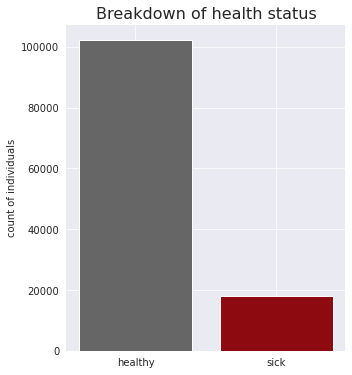

In [473]:
n_sick = df['SH202'].sum()
n_healthy = df['HV009'].sum() - n_sick

health = pd.Series({'healthy': n_healthy, 'sick': n_sick})

fig, ax = plt.subplots(figsize=(5,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

plt.bar(health.index, health.values, color=['#666666']*1 + ['#8d0a11']*1, width=0.8)

plt.title('Breakdown of health status', fontsize=16)
plt.ylabel('count of individuals')
plt.show()

In [474]:
n_healthy

102183.0

In [475]:
temp = df[['SHPROV', 'HV270', 'HV009', 'SH201', 'SH202']].copy()

sick = temp.groupby('SHPROV', as_index=False).agg(population=('HV009',sum), sick=('SH202', sum))
sick['sick_prop'] = sick['sick'] / sick['population']

The graph below shows a map of proportion of sick people across the 82 provinces in the Philippines.

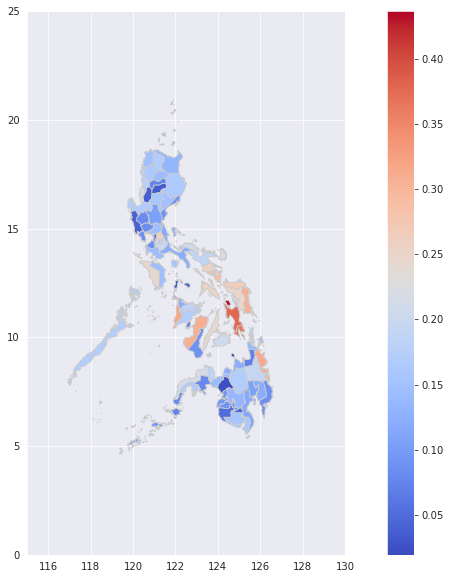

In [476]:
sick_graph_df = pd.merge(shapefile, sick, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(sick_graph_df, 'sick_prop', color='coolwarm')

In [477]:
def bin_data(df, col, bins=3):
    """Bin the data based on their percentile ranking"""
    df['pct_rank'] = df[col].rank(pct=True, ascending=True)
    df['pct_score'] = pd.cut(df.pct_rank, bins,
                            labels=range(1, bins+1)).astype(float)
    df.pct_rank.fillna(bins, inplace=True)
    df.loc[df[df.pct_score == 3].index, 'pct_label'] = 'High'
    df.loc[df[df.pct_score == 2].index, 'pct_label'] = 'Medium'
    df.loc[df[df.pct_score == 1].index, 'pct_label'] = 'Low'
    
    return df

def plot_map(df_binned, fig_title, img_title, save_fig=False):
    """Plot the binned map with Low, Medium, High scaling"""
    df_binned.plot(figsize=(20,20),
                   column='pct_score',
                   categorical=True,
                   cmap='Reds',
#                         legend=True,
                   edgecolor='black',
                   linewidth=0.5)

    # Create the legend
    
    # If reverse: Priority to help is High
    low_patch = mpatches.Patch(color='#FFF5F0', label='Healthy') 
    med_patch = mpatches.Patch(color='#FB694A', label='Neutral')
    high_patch = mpatches.Patch(color='#67000D', label='Sick')
        
    leg = plt.legend(handles=[low_patch, med_patch, high_patch], fontsize=13,
               loc='upper left', title=f'{fig_title}',
               title_fontsize=14)
    leg._legend_box.align = 'left'
    
    # Annotate texts
    # df_no_water_binned.apply(lambda z: ax.annotate(text=z['NAME_1'], color='black', # white
    #                                    xy=z.geometry.representative_point().coords[0],
    #                                    ha='center', fontsize=12)
    #                                    if z['pct_label'] == 'Low' else 'Error', axis=1)
    plt.axis('off');
    
    if save_fig:
        plt.savefig(f'{img_title}.png', dpi=150, bbox_inches='tight')

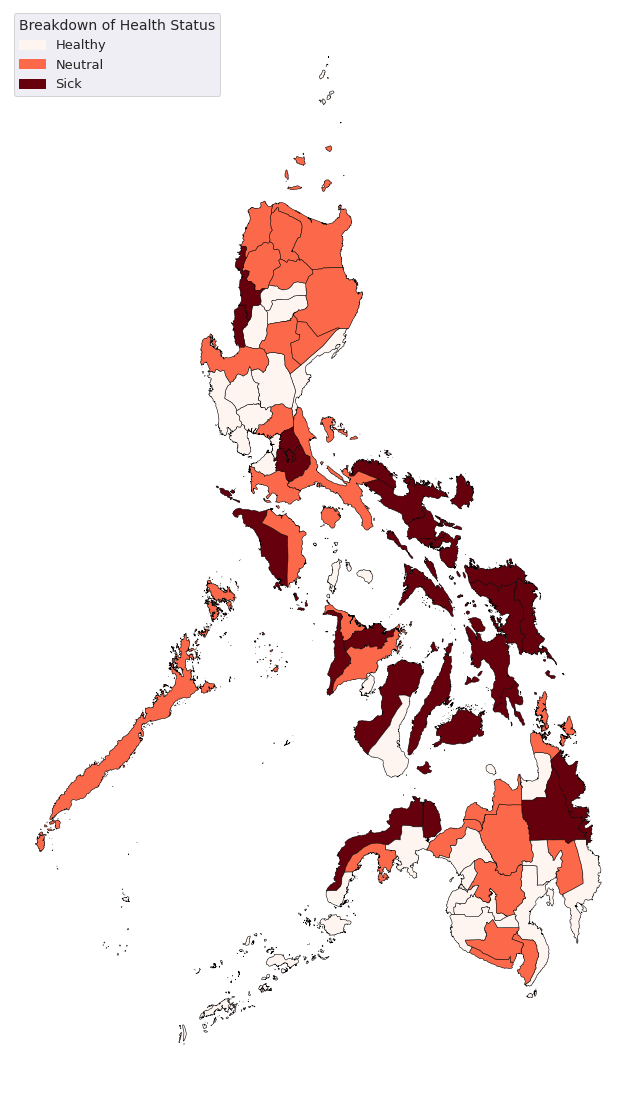

In [478]:
df_sick_binned = bin_data(sick_graph_df, 'sick_prop')

fig_title = 'Breakdown of Health Status'
img_title = 'eda_sickness'

plot_map(df_sick_binned, fig_title, img_title, True) #

The top 5 provinces with the highest proportion of sick individuals (at least 30 percent) are `Biliran`, `Leyte`, `Southern Leyte`, `Antique`, and `Surigao Del Sur`.

In [479]:
sick.sort_values('sick_prop', ascending=False).head(5)

SHPROV  population   sick  sick_prop
13          Biliran      1173.0  512.0   0.436488
43            Leyte      1786.0  675.0   0.377940
71   Southern Leyte      1235.0  454.0   0.367611
5           Antique      1258.0  399.0   0.317170
75  Surigao Del Sur      1290.0  405.0   0.313953

Provinces with the least proportion of sick individuals (at most ~4 percent) are `Romblon`, `Benguet`, `Ifugao`, `Lanao Del Sur`, `Camiguin`.

In [480]:
sick.sort_values('sick_prop', ascending=False).tail(5)

SHPROV  population  sick  sick_prop
65        Romblon      1160.0  42.0   0.036207
12        Benguet      1726.0  62.0   0.035921
33         Ifugao      1343.0  46.0   0.034252
42  Lanao Del Sur      1940.0  47.0   0.024227
20       Camiguin      1231.0  24.0   0.019496

### Proportion of poor households

Looking at the wealth index breakdown, biggest categories are the poorest and poorer households. In a black and white POV, about 50 percent of the total surveyed households are considered poor.

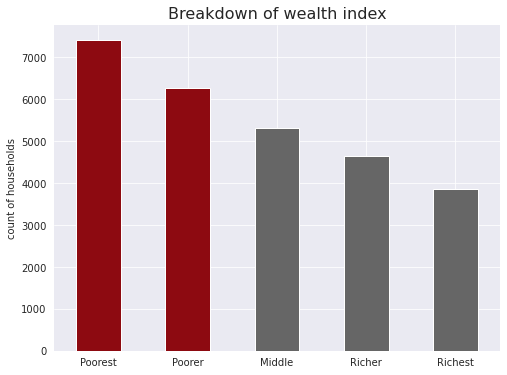

In [481]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

df['HV270'].value_counts().plot(kind='bar', color=['#8d0a11']*2 + ['#666666']*3)

plt.title('Breakdown of wealth index', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

In [482]:
poor_labels = ['Poorer', 'Poorest']

temp = df[['HHID','SHPROV', 'HV270', 'HV009', 'SH201', 'SH202']].copy()

hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
poor = temp[temp['HV270'].isin(poor_labels)].groupby('SHPROV', as_index=False).agg(poor=('HHID', 'count'))

poor = pd.merge(poor, hh, on='SHPROV')
poor['poor_prop'] = poor['poor'] / poor['households']

The map below shows the distribution of the poorest households in the Philippines. Poorer provinces are in the southern part of the country.

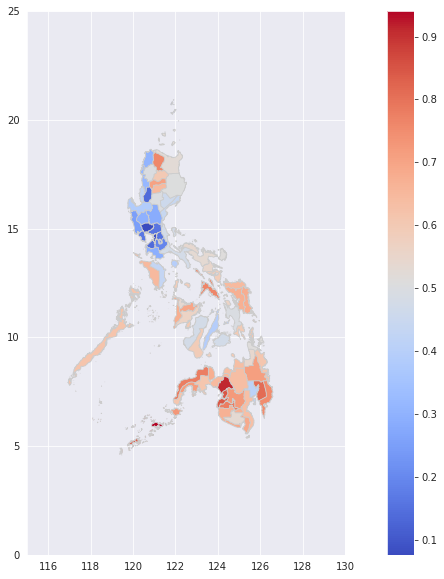

In [483]:
poor_graph_df = pd.merge(shapefile, poor, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(poor_graph_df, 'poor_prop', color='coolwarm')

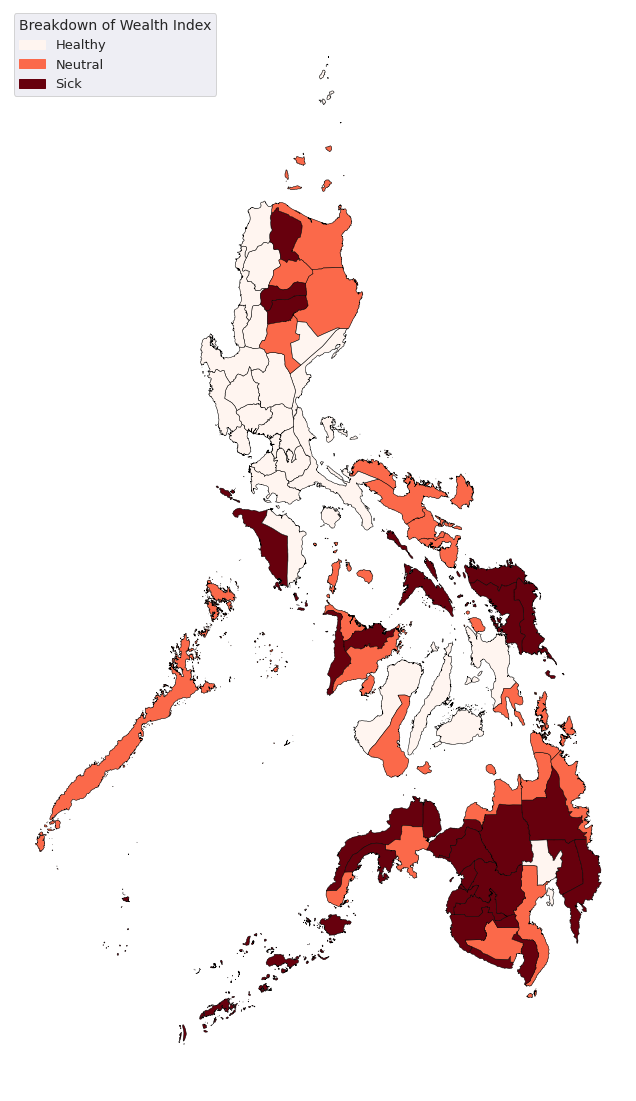

In [484]:
df_poor_binned = bin_data(poor_graph_df, 'poor_prop')

fig_title = 'Breakdown of Wealth Index'
img_title = 'eda_wealth'

plot_map(df_poor_binned, fig_title, img_title, True) #

Poorest provinces are `Sulu`, `Lanao Del Sur`, `Davao Occidental`, `Tawi-Tawi`, and `Compostella Valley`.

In [485]:
poor.sort_values('poor_prop', ascending=False).head(5)

SHPROV  poor  households  poor_prop
73               Sulu   300         319   0.940439
42      Lanao Del Sur   315         345   0.913043
28   Davao Occidental   248         294   0.843537
77          Tawi-Tawi   179         213   0.840376
25  Compostela Valley   216         267   0.808989

Least poor provinces (and region) are `Benguet`, `Cavite`, `Batanes`, `Metro Manila`, and `Pampanga`.

In [486]:
poor.sort_values('poor_prop', ascending=False).tail(5)

SHPROV  poor  households  poor_prop
12              Benguet    65         473   0.137421
23               Cavite    36         262   0.137405
10              Batanes    25         248   0.100806
47  Metropolitan Manila   190        2383   0.079731
60             Pampanga    29         383   0.075718

A simple quadrant analysis of health and wealth disposition of the different provinces can tell us which specific province needs what kind of assistance. Provinces with relatively high sick AND poor proportions should be priority in terms of aid. 

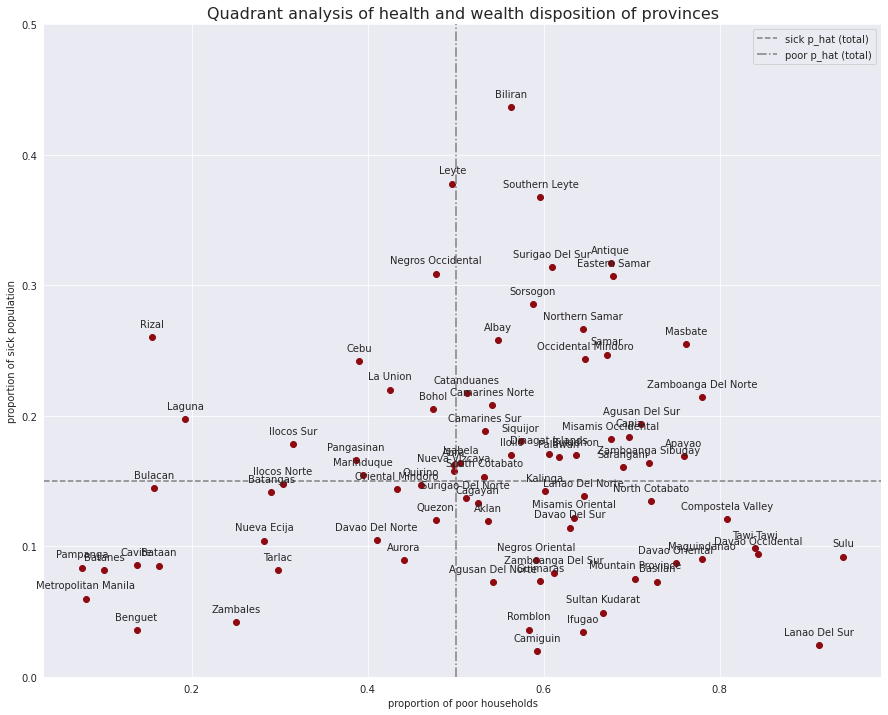

In [260]:
fig, ax = plt.subplots(figsize=(15,12))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

plt.scatter(poor['poor_prop'], sick['sick_prop'], color='#8d0a11')
plt.axhline(y = 0.15, color = 'grey', linestyle = '--', label='sick p_hat (total)')
plt.axvline(x = 0.5, color = 'grey', linestyle = '-.', label='poor p_hat (total)')

for label, x, y, in zip(poor['SHPROV'], poor['poor_prop'], sick['sick_prop']):
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
    
plt.title('Quadrant analysis of health and wealth disposition of provinces', fontsize=16)
plt.ylabel('proportion of sick population')
plt.xlabel('proportion of poor households')

plt.legend()
plt.ylim(0,0.5)
plt.xticks(rotation=0)
plt.show()

## Difference in proportion of sick population between poor and non-poor households

For this portion, we test if there is a significant difference between the proportion of sick people among poor and non-poor population. The idea is to test if poverty contributes to people's sickness. The null hypothesis is that there is no difference in the proportion of sick people among poor and non-poor. The alternative hypothesis is that there are more sick people among the poor population.

\begin{equation}
H_0:\,\hat{p}_{\rm poor} = \hat{p}_{\rm non-poor} \\
H_1:\,\hat{p}_{\rm poor} > \hat{p}_{\rm non-poor}
\end{equation}

In [261]:
poor_labels = ['Poorer', 'Poorest']

temp_poor = df[df['HV270'].isin(poor_labels)].copy()
n_poor_sick = temp_poor['SH202'].sum()
n_poor = temp_poor['HV009'].sum()

p_poor_sick_hat = n_poor_sick/n_poor
obs_poor = np.array([1]*int(n_poor_sick) + [0]*int(n_poor - n_poor_sick))

print(f'Estimated proportion of sick people among poor population: {p_poor_sick_hat}')

Estimated proportion of sick people among poor population: 0.1623887548864676


In [262]:
temp_nonpoor = df[~df['HV270'].isin(poor_labels)].copy()
n_nonpoor_sick = temp_nonpoor['SH202'].sum()
n_nonpoor = temp_nonpoor['HV009'].sum()

p_nonpoor_sick_hat = n_nonpoor_sick/n_nonpoor
obs_nonpoor = np.array([1]*int(n_nonpoor_sick) + [0]*int(n_nonpoor - n_nonpoor_sick))
print(f'Estimated proportion of sick people among non-poor population: {p_nonpoor_sick_hat}')

Estimated proportion of sick people among non-poor population: 0.13843545330629342


From our checks of the standard errors below, we need to account for an unequal variance in our t-test.

In [263]:
sim_size = 100
n = len(temp_poor) 

sick_props = list()

for i in trange(sim_size):    
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    temp = temp_poor.iloc[samp_ind].copy()
    temp_prop = temp['SH202'].sum() / temp['HV009'].sum()
    sick_props.append(temp_prop)

print(f'Standard Error, proportion of poor sick people: {np.std(sick_props, ddof=1):.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Standard Error, proportion of poor sick people: 0.002017


In [264]:
sim_size = 100
n = len(temp_nonpoor) 

sick_props = list()

for i in trange(sim_size):    
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    temp = temp_nonpoor.iloc[samp_ind].copy()
    temp_prop = temp['SH202'].sum() / temp['HV009'].sum()
    sick_props.append(temp_prop)

print(f'Standard Error, proportion of non-poor sick people: {np.std(sick_props, ddof=1):.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Standard Error, proportion of non-poor sick people: 0.001837


Looking at the results of our t-test, we have sufficient evidence to reject the null hypothesis that the proportions of sick people among poor and non-poor population are equal. More poor people get sick than non-poor.

In [265]:
from statsmodels.stats.weightstats import ztest, ttest_ind

tstat, pvalue, dof = ttest_ind(obs_poor, obs_nonpoor, usevar='unequal', value=0, alternative='larger')

print(f't-stat = {tstat}')
print(f'p-value = {pvalue}')
print(f'degrees of freedom = {dof}')
print('')
print(f'The p-value {pvalue:.8f} is less than alpha=0.05. We reject the null.')

t-stat = 11.625430827891865
p-value = 1.5905573263483884e-31
degrees of freedom = 119744.39125780623

The p-value 0.00000000 is less than alpha=0.05. We reject the null.


## Access to Water

### Proportion of households without an on-premise water source

In [564]:
no_water_labels = ['Off premises']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV201', 'HV204', 'HV237']].copy()
temp.loc[(temp['HV204'] != 'On premises'), 'HV204'] = 'Off premises'
hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
naw = temp[temp['HV204'].isin(no_water_labels)].groupby('SHPROV', as_index=False).agg(no_water=('HHID', 'count'))

no_water = pd.merge(naw, hh, on='SHPROV')
no_water['no_water_prop'] = no_water['no_water'] / no_water['households']

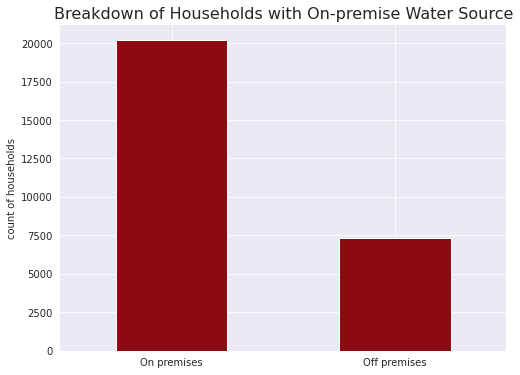

In [565]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

temp['HV204'].value_counts().plot(kind='bar', color=['#8d0a11']*2 + ['#666666']*3)

plt.title('Breakdown of Households with On-premise Water Source', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

The map below shows the distribution of households with no on-premise water source the Philippines. Red colored land areas are provinces where people mostly fetch water from an unowned water source.

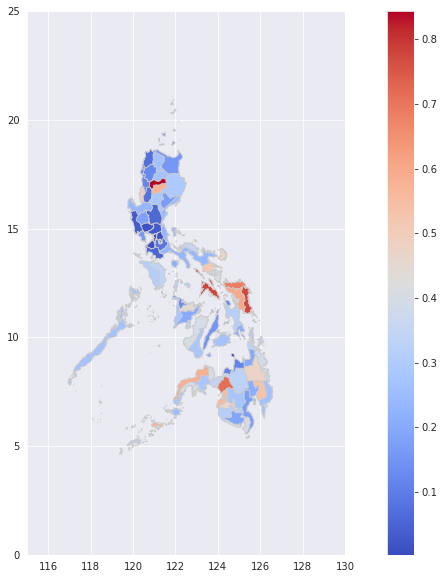

In [566]:
no_water_graph_df = pd.merge(shapefile, no_water, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(no_water_graph_df, 'no_water_prop', color='coolwarm')

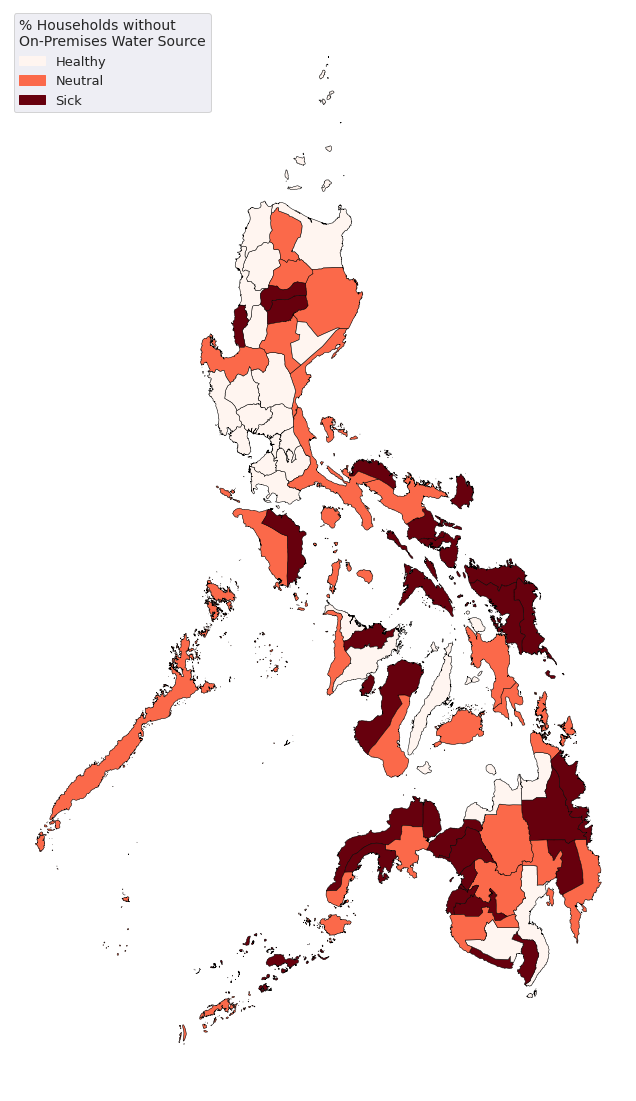

In [567]:
df_no_water_binned = bin_data(no_water_graph_df, 'no_water_prop')

fig_title = '% Households without\nOn-Premises Water Source'
img_title = 'eda_access_to_water1'

plot_map(df_no_water_binned, fig_title, img_title, True) #

Poorest provinces are `Mountain Province`, `Masbate`, `Eastern Samar`, `Lanao Del Sur`, and `Northern Samar	`. It is absurd how most of samar does not have access to an on-premise water-source.

In [568]:
no_water.sort_values('no_water_prop', ascending=False).head(5)

SHPROV  no_water  households  no_water_prop
50  Mountain Province       231         274       0.843066
46            Masbate       229         294       0.778912
31      Eastern Samar       203         262       0.774809
42      Lanao Del Sur       246         345       0.713043
54     Northern Samar       200         293       0.682594

### Proportion of households with no access to safe drinking water

In [569]:
no_water_labels = ['Unbottled water']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV201', 'HV204', 'HV237']].copy()
temp.loc[(temp['HV204'] != 'On premises'), 'HV204'] = 'Off premises'
temp.loc[(temp['HV201'] != 'Bottled water'), 'HV201'] = 'Unbottled water'
temp['is_unsafe'] = 'With Access to Potable Water'
temp.loc[((temp['HV201'] == 'Unbottled water') & (temp['HV237']== 'No')), 'is_unsafe'] = 'No Access to Potable Water'
hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
unsafe = temp.loc[(temp['HV201']== 'Unbottled water') &
               (temp['HV237']== 'No')].groupby('SHPROV', as_index=False).agg(unsafe=('HHID', 'count'))

unsafe = pd.merge(unsafe, hh, on='SHPROV')
unsafe['unsafe_prop'] = unsafe['unsafe'] / unsafe['households']

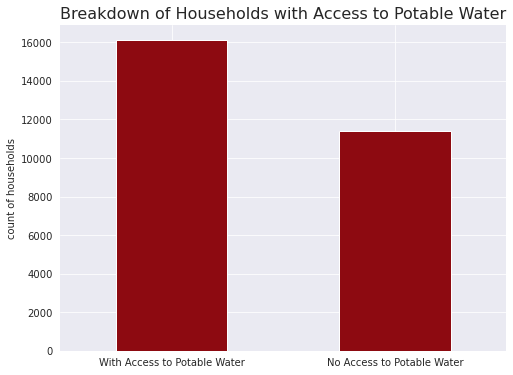

In [570]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

temp['is_unsafe'].value_counts().plot(kind='bar', color=['#8d0a11']*2 + ['#666666']*3)

plt.title('Breakdown of Households with Access to Potable Water', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

The map below shows the distribution of the households without access to potable water. Provinces in the southern part of the country drink directly from untreated water sources.

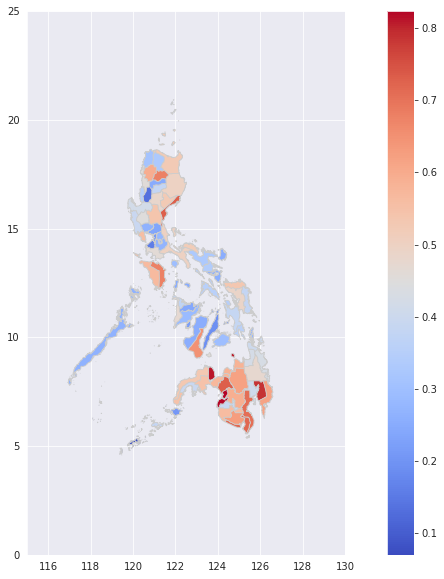

In [571]:
unsafe_graph_df = pd.merge(shapefile, unsafe, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(unsafe_graph_df, 'unsafe_prop', color='coolwarm')

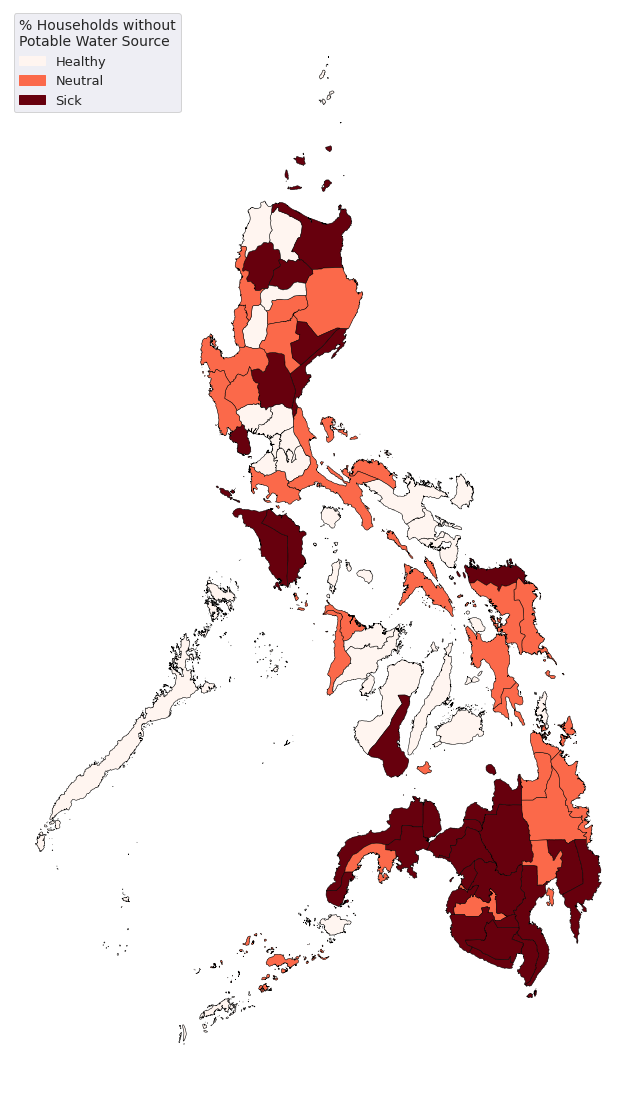

In [572]:
df_unsafe_water_binned = bin_data(unsafe_graph_df, 'unsafe_prop')

fig_title = '% Households without\nPotable Water Source'
img_title = 'eda_access_to_water2'

plot_map(df_unsafe_water_binned, fig_title, img_title, True)

The following are top five (5) provinces that do not have access to potable water: `Davao Occidental`, `Misamis Occidental`, `Camiguin`, `Compostela Valley`, and `Lanao Del Sur`. In fact, more than 70% of households in these provinces drink water directly from untreated water sources.

In [573]:
unsafe.sort_values('unsafe_prop', ascending=False).head(5)

SHPROV  unsafe  households  unsafe_prop
28    Davao Occidental     242         294     0.823129
48  Misamis Occidental     223         275     0.810909
20            Camiguin     230         285     0.807018
25   Compostela Valley     210         267     0.786517
42       Lanao Del Sur     252         345     0.730435

## Access to Electricity

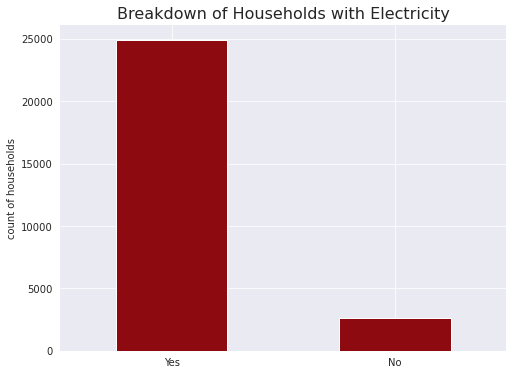

In [574]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

df['HV206'].value_counts().plot(kind='bar', color=['#8d0a11']*2 + ['#666666']*3)

plt.title('Breakdown of Households with Electricity', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

In [575]:
df['HV206'].value_counts()

Yes    24885
No      2611
Name: HV206, dtype: int64

In [576]:
no_electric_labels = ['No']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV206']].copy()


hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
no_elec = temp[temp['HV206'].isin(no_electric_labels)].groupby('SHPROV', as_index=False).agg(no_elec=('HHID', 'count'))

no_elec = pd.merge(no_elec, hh, on='SHPROV')
no_elec['no_elec_prop'] = no_elec['no_elec'] / no_elec['households']

The map below shows the distribution of the households without access to electricity in the Philippines. Land areas shaded in red has the highest proportion of no electricity access.

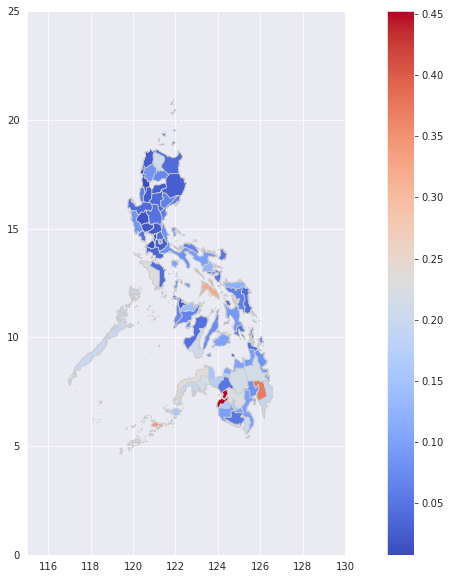

In [577]:
no_elec_graph_df = pd.merge(shapefile, no_elec, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(no_elec_graph_df, 'no_elec_prop', color='coolwarm')

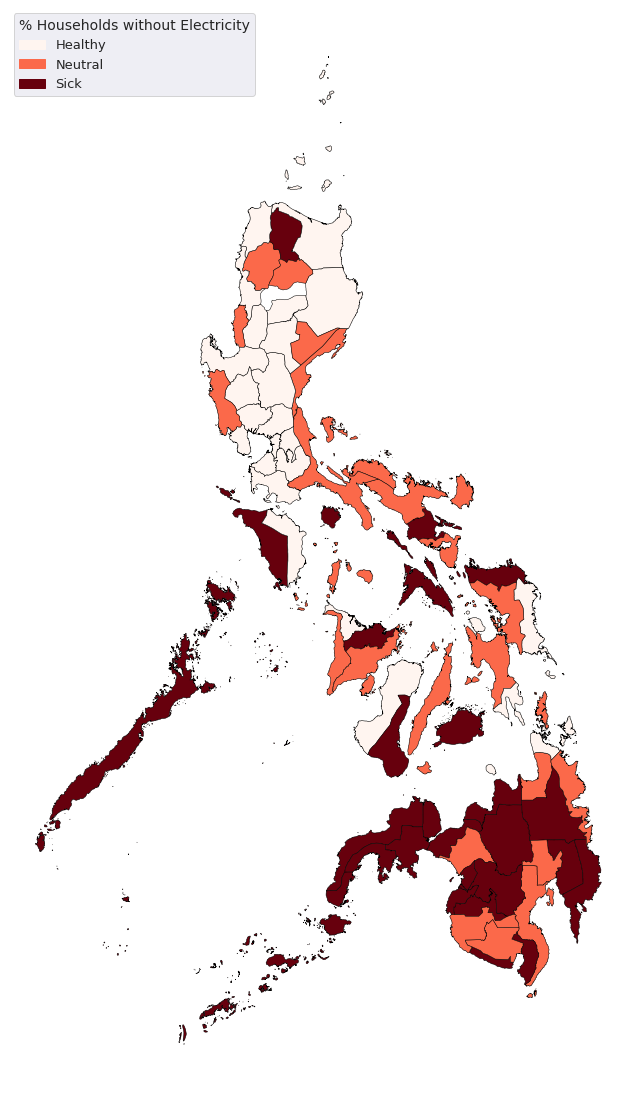

In [578]:
df_no_elec_binned = bin_data(no_elec_graph_df, 'no_elec_prop')

fig_title = '% Households without Electricity'
img_title = 'eda_access_to_elec'

plot_map(df_no_elec_binned, fig_title, img_title, True)

`Davao Occidental`, `Compostela Valley`, `Sulu`, `Masbate`, and `Zamboanga Del Norte` are provinces that has the highest proportion of househoulds without access to electricity. In Davao Occidental, a whopping 45.24% of households are still unpowered.

In [579]:
no_elec.sort_values('no_elec_prop', ascending=False).head(5)

SHPROV  no_elec  households  no_elec_prop
28     Davao Occidental      133         294      0.452381
25    Compostela Valley       99         267      0.370787
72                 Sulu      110         319      0.344828
46              Masbate       96         294      0.326531
78  Zamboanga Del Norte       60         250      0.240000

## Access to Toilet

### Poor Toilet Practices

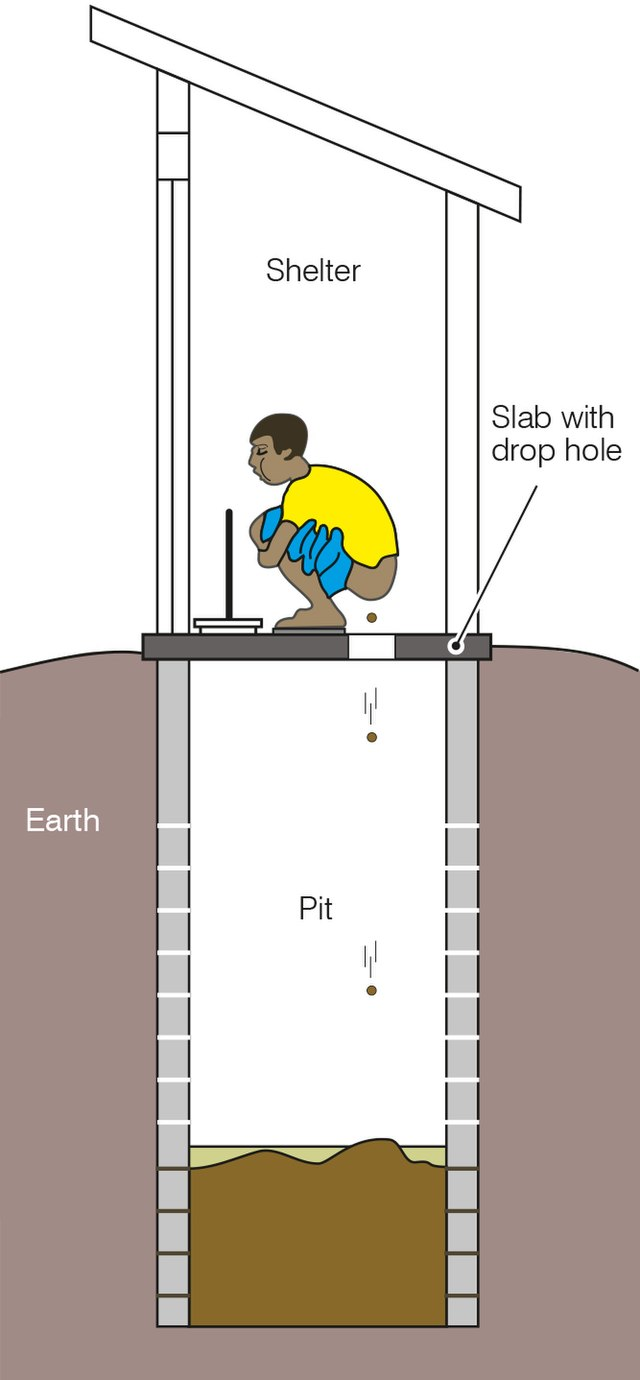

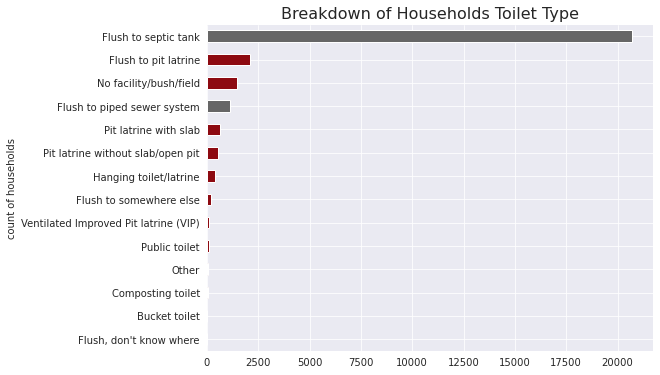

In [580]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

color_toilet = ['#8d0a11']*10 + ['#666666']*1 + ['#8d0a11']*2 + ['#666666']*1
df['HV205'].value_counts(ascending=True).plot(kind='barh', color=color_toilet)

plt.title('Breakdown of Households Toilet Type', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

In [581]:
poor_toilet_labels = ['Composting toilet', 'Flush to pit latrine', 'Hanging toilet/latrine',
                      'Flush to somewhere else', "Flush, don't know where", 'No facility/bush/field',
                      'Pit latrine with slab', 'Public toilet', 'Pit latrine without slab/open pit',
                      'Ventilated Improved Pit latrine (VIP)', 'Bucket toilet', 'Other']

temp = df[['HHID','SHPROV', 'HV009', 'HV205']].copy()

hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
poor_toilet = temp[temp['HV205'].isin(poor_toilet_labels)].groupby('SHPROV', as_index=False).agg(poor_toilet=('HHID', 'count'))

poor_toilet = pd.merge(poor_toilet, hh, on='SHPROV')
poor_toilet['poor_toilet_prop'] = poor_toilet['poor_toilet'] / poor_toilet['households']

The map below shows the distribution of the households toilet practices. Land areas shaded red still practice bad toilet practices.

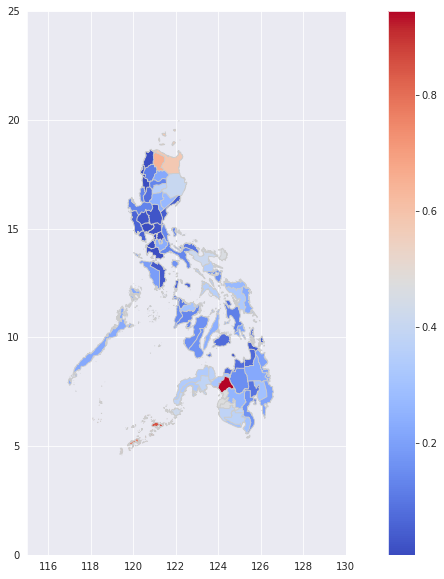

In [582]:
poor_toilet_graph_df = pd.merge(shapefile, poor_toilet, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(poor_toilet_graph_df, 'poor_toilet_prop', color='coolwarm')

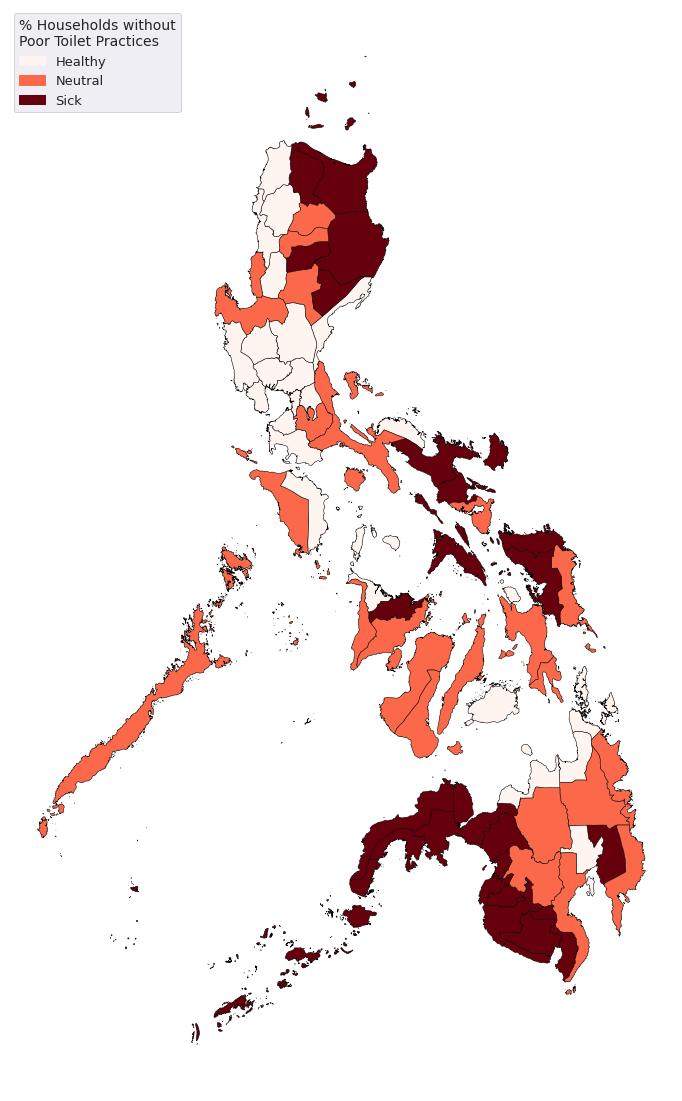

In [583]:
df_poor_toilet_binned = bin_data(poor_toilet_graph_df, 'poor_toilet_prop')

fig_title = '% Households without\nPoor Toilet Practices'
img_title = 'eda_access_to_toilet'

plot_map(df_poor_toilet_binned, fig_title, img_title, True)

`Lanao Del Sur`, `Sulu`, `Tawi-Tawi`, `Apayao`, and `Cagayan` are the top provinces that practice bad toilet practices in the Philippines. Some of the poorest provinces still practice open defecation

In [584]:
poor_toilet.sort_values('poor_toilet_prop', ascending=False).head(5)

SHPROV  poor_toilet  households  poor_toilet_prop
41  Lanao Del Sur          326         345          0.944928
72           Sulu          272         319          0.852665
76      Tawi-Tawi          167         213          0.784038
6          Apayao          178         274          0.649635
16        Cagayan          161         278          0.579137

In [585]:
df['HV226'].unique()

array(['LPG', 'Charcoal', 'Wood', 'Electricity', 'Kerosene',
       'Natural gas', 'Coal, lignite', 'Biogas',
       'No food cooked in house', 'Straw/shrubs/grass',
       'Agricultural crop'], dtype=object)

In [586]:
meta.column_names_to_labels

{'HHID': 'Case Identification',
 'HV000': 'Country code and phase',
 'HV001': 'Cluster number',
 'HV002': 'Household number',
 'HV003': "Respondent's line number (answering Household questionnaire)",
 'HV004': 'Ultimate area unit',
 'HV005': 'Household sample weight (6 decimals)',
 'HV006': 'Month of interview',
 'HV007': 'Year of interview',
 'HV008': 'Date of interview (CMC)',
 'HV008A': 'Date of interview Century Day Code (CDC)',
 'HV009': 'Number of household members',
 'HV010': 'Number of eligible women in household',
 'HV011': 'NA - Number of eligible men in household',
 'HV012': 'Number of de jure members',
 'HV013': 'Number of de facto members',
 'HV014': 'Number of children 5 and under (de jure)',
 'HV015': 'Result of household interview',
 'HV016': 'Day of interview',
 'HV017': 'Number of visits',
 'HV018': 'Interviewer identification',
 'HV019': 'NA - Keyer identification',
 'HV020': 'Ever-married sample',
 'HV021': 'Primary sampling unit',
 'HV022': 'Sample strata for sampl

## Poverty Index (Per House Hold Measure)

In [589]:
df_merge = poor.merge(no_water, on='SHPROV', how='left')
df_merge = df_merge.merge(unsafe, on='SHPROV', how='left')
df_merge = df_merge.merge(no_elec, on='SHPROV', how='left')
df_merge = df_merge.merge(poor_toilet, on='SHPROV', how='left')
df_index_hh = df_merge[['SHPROV','no_water_prop', 'unsafe_prop', 'no_elec_prop', 'poor_toilet_prop']]
df_index_hh['pov_index'] = ((0.25 * df_index_hh['no_water_prop']) +
                         (0.25 * df_index_hh['unsafe_prop']) +
                         (0.25 * df_index_hh['no_elec_prop']) +
                         (0.25 * df_index_hh['poor_toilet_prop']))
df_index_hh = df_index_hh.sort_values('pov_index', ascending=False)
df_index_hh

SHPROV  no_water_prop  unsafe_prop  no_elec_prop  \
42        Lanao Del Sur       0.713043     0.730435      0.052174   
28     Davao Occidental       0.554422     0.823129      0.452381   
73                 Sulu       0.576803     0.382445      0.344828   
25    Compostela Valley       0.531835     0.786517      0.370787   
46              Masbate       0.778912     0.353741      0.326531   
..                  ...            ...          ...           ...   
60             Pampanga       0.015666     0.266319      0.018277   
47  Metropolitan Manila       0.003357     0.211498      0.011750   
23               Cavite       0.015267     0.156489      0.011450   
10              Batanes       0.032258     0.282258      0.016129   
50    Mountain Province       0.843066     0.248175           NaN   

    poor_toilet_prop  pov_index  
42          0.944928   0.610145  
28          0.472789   0.575680  
73          0.852665   0.539185  
25          0.299625   0.497191  
46          0.357143   0.454082  
..               ...        ...  
60          0.007833   0.077023  
47          0.019723   0.061582  
23          0.011450   0.048664  
10               NaN        NaN  
50          0.135036        NaN  

[82 rows x 6 columns]

## Clustering

### On-Premise vs Off-Premise

In [359]:
no_water_labels = ['Off premises']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV204']].copy()
temp.loc[(temp['HV204'] != 'On premises'), 'HV204'] = 'Off premises'
hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
naw = temp[temp['HV204'].isin(no_water_labels)].groupby('SHPROV', as_index=False).agg(off_premise=('HHID', 'count'))
waw = temp[~temp['HV204'].isin(no_water_labels)].groupby('SHPROV', as_index=False).agg(on_premise=('HHID', 'count'))

temp = temp.rename(columns={"HV204": "fetch_location"})
temp = pd.get_dummies(temp, columns=['fetch_location'], drop_first=True)
water_df = temp.groupby('SHPROV', as_index=False).sum()
water_df = water_df.drop(['HHID', 'HV009'], axis=1)
water_df


SHPROV  fetch_location_On premises
0                  Abra                       236.0
1      Agusan Del Norte                       334.0
2        Agusan Del Sur                       148.0
3                 Aklan                       251.0
4                 Albay                       134.0
..                  ...                         ...
77            Tawi-Tawi                       145.0
78             Zambales                       401.0
79  Zamboanga Del Norte                       104.0
80    Zamboanga Del Sur                       284.0
81    Zamboanga Sibugay                       156.0

[82 rows x 2 columns]

### Potable Water

In [360]:
map_drink = {'Piped into dwelling': 'Pipe',
             'Piped to neighbor': 'Pipe',
             'Piped to yard/plot': 'Pipe',
             'Public tap/standpipe': 'Pipe',
             'Protected well': 'Well',
             'Unprotected well': 'Well',
             'Tube well or borehole': 'Well',
             'Other': 'Well',
             'Protected spring': 'Spring',
             'Unprotected spring': 'Spring',
             'River/dam/lake/ponds/stream/canal/irrigation channel': 'Stream',
             'Rainwater': 'Rain',
             'Tanker truck': 'Tanker',
             'Cart with small tank': 'Tanker',             
             'Bottled water': 'Bottled'}


temp = df[['HHID', 'SHPROV', 'HV009', 'HV201', 'HV237']].copy()

temp = temp.replace({'HV201': map_drink})
temp.loc[temp['HV237'] == "Don't know", 'HV237'] = 'No'

hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
unsafe = temp.loc[(temp['HV201']== 'Unbottled water') &
               (temp['HV237']== 'No')].groupby('SHPROV', as_index=False).agg(unsafe=('HHID', 'count'))

temp = temp.rename(columns={"HV201": "Source", "HV237": "Treatment"})
temp = pd.get_dummies(temp, columns=['Source', 'Treatment'], drop_first=True)
unsafe = temp.groupby('SHPROV', as_index=False).sum()
unsafe = unsafe.drop(['HHID', 'HV009'], axis=1)
unsafe

SHPROV  Source_Pipe  Source_Rain  Source_Spring  \
0                  Abra         80.0          0.0          114.0   
1      Agusan Del Norte        105.0          2.0           54.0   
2        Agusan Del Sur         90.0         28.0           16.0   
3                 Aklan         82.0          1.0           19.0   
4                 Albay         55.0          0.0           38.0   
..                  ...          ...          ...            ...   
77            Tawi-Tawi          4.0        110.0            3.0   
78             Zambales        133.0          0.0           24.0   
79  Zamboanga Del Norte         39.0          0.0          111.0   
80    Zamboanga Del Sur        201.0          0.0           42.0   
81    Zamboanga Sibugay        128.0          0.0           20.0   

    Source_Stream  Source_Tanker  Source_Well  Treatment_Yes  
0            10.0            0.0         46.0           93.0  
1             0.0            0.0         53.0           60.0  
2             0.0           12.0         52.0           67.0  
3             0.0            0.0         98.0           96.0  
4             0.0            0.0        102.0          102.0  
..            ...            ...          ...            ...  
77            0.0            4.0         72.0          186.0  
78            0.0            0.0         86.0          100.0  
79            0.0            0.0         52.0           73.0  
80            0.0            0.0         55.0           90.0  
81            1.0            5.0         43.0          106.0  

[82 rows x 8 columns]

### Electricity

In [361]:
no_electric_labels = ['No']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV206']].copy()

hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))
temp = temp.rename(columns={"HV206": "Electricity"})
temp = pd.get_dummies(temp, columns=['Electricity'], drop_first=True)

no_elec = temp.groupby('SHPROV', as_index=False).sum()
no_elec = no_elec.drop(['HHID', 'HV009'], axis=1)
no_elec = no_elec.rename(columns={"Electricity_Yes": "Electricity_No"})
no_elec

SHPROV  Electricity_No
0                  Abra           246.0
1      Agusan Del Norte           377.0
2        Agusan Del Sur           224.0
3                 Aklan           282.0
4                 Albay           243.0
..                  ...             ...
77            Tawi-Tawi           168.0
78             Zambales           380.0
79  Zamboanga Del Norte           190.0
80    Zamboanga Del Sur           309.0
81    Zamboanga Sibugay           210.0

[82 rows x 2 columns]

### Loo

In [362]:
map_loo = {'Flush to septic tank': 'Home_Piped',
             'Flush to piped sewer system': 'Home_Piped',
             
             'Flush to pit latrine': 'Pit_Latrine',
             'Hanging toilet/latrine': 'Pit_Latrine',
             'Pit latrine with slab': 'Pit_Latrine',
             'Pit latrine without slab/open pit': 'Pit_Latrine',
             'Ventilated Improved Pit latrine (VIP)': 'Pit_Latrine',
             
             'Composting toilet': 'Closed_Defecation',
             'Public toilet': 'Closed_Defecation',
             'Bucket toilet': 'Closed_Defecation',
             
             'Flush to somewhere else': 'Open_Defecation',
             "Flush, don't know where": 'Open_Defecation',
             'Other': 'Open_Defecation',
             'No facility/bush/field': 'Open_Defecation'}

poor_toilet_labels = ['Composting toilet', 'Flush to pit latrine', 'Hanging toilet/latrine',
                      'Flush to somewhere else', "Flush, don't know where", 'No facility/bush/field',
                      'Pit latrine with slab', 'Public toilet', 'Pit latrine without slab/open pit',
                      'Ventilated Improved Pit latrine (VIP)', 'Bucket toilet', 'Other']

temp = df[['HHID','SHPROV', 'HV009', 'HV205']].copy()
temp = temp.replace({'HV205': map_loo})
temp = temp.rename(columns={"HV205": "Loo"})
temp = pd.get_dummies(temp, columns=['Loo'], drop_first=True)

hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'))

loo = temp.groupby('SHPROV', as_index=False).sum()
loo = loo.drop(['HHID', 'HV009'], axis=1)
loo

SHPROV  Loo_Home_Piped  Loo_Open_Defecation  Loo_Pit_Latrine
0                  Abra           238.0                  1.0             28.0
1      Agusan Del Norte           387.0                 11.0             18.0
2        Agusan Del Sur           220.0                  7.0             53.0
3                 Aklan           258.0                 18.0             13.0
4                 Albay           181.0                  0.0             98.0
..                  ...             ...                  ...              ...
77            Tawi-Tawi            46.0                 21.0            146.0
78             Zambales           390.0                 14.0              7.0
79  Zamboanga Del Norte           165.0                 18.0             67.0
80    Zamboanga Del Sur           243.0                 35.0            115.0
81    Zamboanga Sibugay           174.0                 17.0             68.0

[82 rows x 4 columns]

### Merging

In [363]:
df_province = water_df.merge(unsafe, on='SHPROV', how='left')
df_province = df_province.merge(no_elec, on='SHPROV', how='left')
df_province = df_province.merge(loo, on='SHPROV', how='left')
df_province = df_province.set_index('SHPROV')

# Scaling Dataset
new_val = df_province.values / hh['households'].values.reshape(-1,1)
df_province_norm = pd.DataFrame(data=new_val,
                                index=df_province.index,
                                columns=df_province.columns)
df_province_norm

fetch_location_On premises  Source_Pipe  Source_Rain  \
SHPROV                                                                      
Abra                                   0.877323     0.297398     0.000000   
Agusan Del Norte                       0.800959     0.251799     0.004796   
Agusan Del Sur                         0.521127     0.316901     0.098592   
Aklan                                  0.868512     0.283737     0.003460   
Albay                                  0.480287     0.197133     0.000000   
...                                         ...          ...          ...   
Tawi-Tawi                              0.680751     0.018779     0.516432   
Zambales                               0.966265     0.320482     0.000000   
Zamboanga Del Norte                    0.416000     0.156000     0.000000   
Zamboanga Del Sur                      0.720812     0.510152     0.000000   
Zamboanga Sibugay                      0.600000     0.492308     0.000000   

                     Source_Spring  Source_Stream  Source_Tanker  Source_Well  \
SHPROV                                                                          
Abra                      0.423792       0.037175       0.000000     0.171004   
Agusan Del Norte          0.129496       0.000000       0.000000     0.127098   
Agusan Del Sur            0.056338       0.000000       0.042254     0.183099   
Aklan                     0.065744       0.000000       0.000000     0.339100   
Albay                     0.136201       0.000000       0.000000     0.365591   
...                            ...            ...            ...          ...   
Tawi-Tawi                 0.014085       0.000000       0.018779     0.338028   
Zambales                  0.057831       0.000000       0.000000     0.207229   
Zamboanga Del Norte       0.444000       0.000000       0.000000     0.208000   
Zamboanga Del Sur         0.106599       0.000000       0.000000     0.139594   
Zamboanga Sibugay         0.076923       0.003846       0.019231     0.165385   

                     Treatment_Yes  Electricity_No  Loo_Home_Piped  \
SHPROV                                                               
Abra                      0.345725        0.914498        0.884758   
Agusan Del Norte          0.143885        0.904077        0.928058   
Agusan Del Sur            0.235915        0.788732        0.774648   
Aklan                     0.332180        0.975779        0.892734   
Albay                     0.365591        0.870968        0.648746   
...                            ...             ...             ...   
Tawi-Tawi                 0.873239        0.788732        0.215962   
Zambales                  0.240964        0.915663        0.939759   
Zamboanga Del Norte       0.292000        0.760000        0.660000   
Zamboanga Del Sur         0.228426        0.784264        0.616751   
Zamboanga Sibugay         0.407692        0.807692        0.669231   

                     Loo_Open_Defecation  Loo_Pit_Latrine  
SHPROV                                                     
Abra                            0.003717         0.104089  
Agusan Del Norte                0.026379         0.043165  
Agusan Del Sur                  0.024648         0.186620  
Aklan                           0.062284         0.044983  
Albay                           0.000000         0.351254  
...                                  ...              ...  
Tawi-Tawi                       0.098592         0.685446  
Zambales                        0.033735         0.016867  
Zamboanga Del Norte             0.072000         0.268000  
Zamboanga Del Sur               0.088832         0.291878  
Zamboanga Sibugay               0.065385         0.261538  

[82 rows x 12 columns]

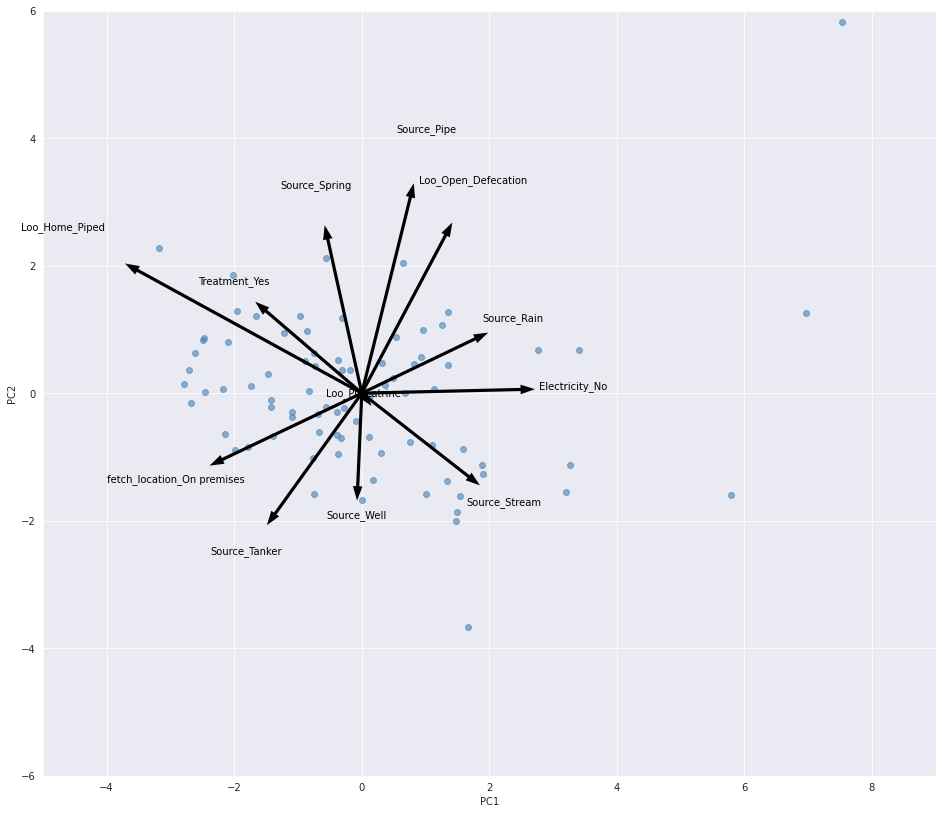

In [364]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

sns.set_style({'axes.grid' : False})
palette = sns.color_palette('flare', as_cmap=True)
sns.set_style('darkgrid')

# Scaling Dataset
standard_scaler = StandardScaler()
X_soccer = standard_scaler.fit_transform(df_province_norm)

# DR with PCA

pca = PCA(n_components=12)
pca.fit(X_soccer)
X_new_pca = pca.transform(X_soccer)
w_pca = pca.components_
variance_explained_pca = pca.explained_variance_ratio_
fig, ax = plt.subplots(1, 1, subplot_kw=dict(aspect='equal'), figsize=(16, 16))
plt.scatter(X_new_pca[:,0], X_new_pca[:,1], c='steelblue', alpha=0.6)
features = df_province_norm.columns
for feature, vec in zip(features, w_pca):
    ax.arrow(0, 0, 6*vec[0], 6*vec[1], width=0.05, ec='none', fc='black')
    ax.text(8*vec[0], 8*vec[1], feature, ha='center', color='black')
ax.set_xlim(-5, 9)
ax.set_ylim(-6, 6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

In [365]:
from sklearn.decomposition import TruncatedSVD

# DR with SVD

svd = TruncatedSVD(n_components=12, random_state=1337)
X_new_svd = svd.fit_transform(X_soccer)
variance_explained_svd = svd.explained_variance_ratio_
p_svd = svd.components_

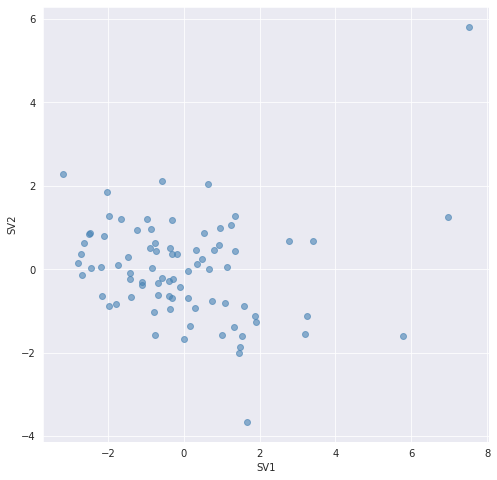

In [366]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_new_svd[:,0], X_new_svd[:,1], c='steelblue', alpha=0.6)
plt.xlabel('SV1')
plt.ylabel('SV2');

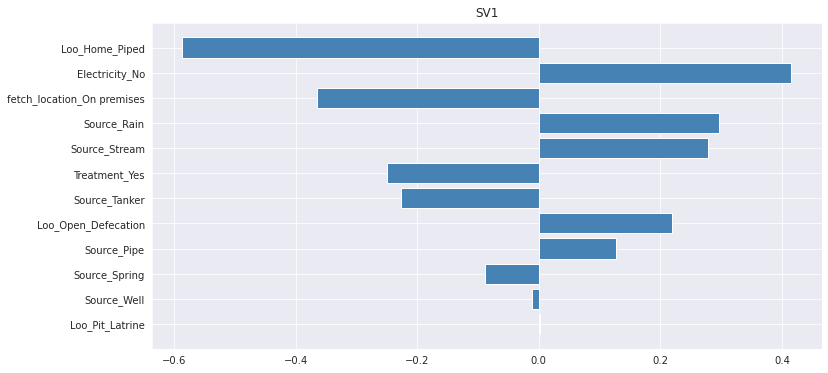

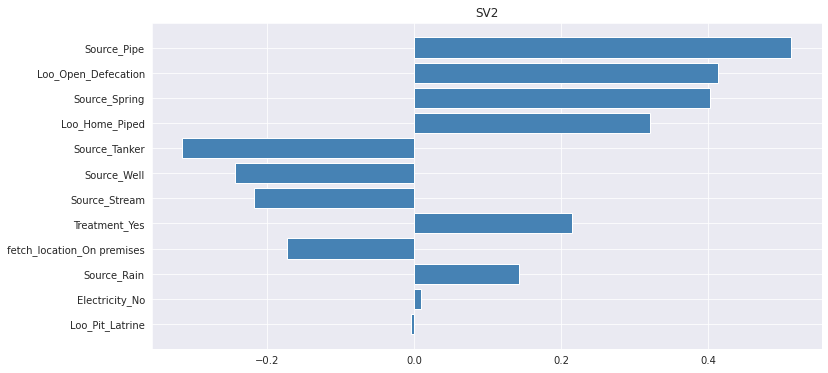

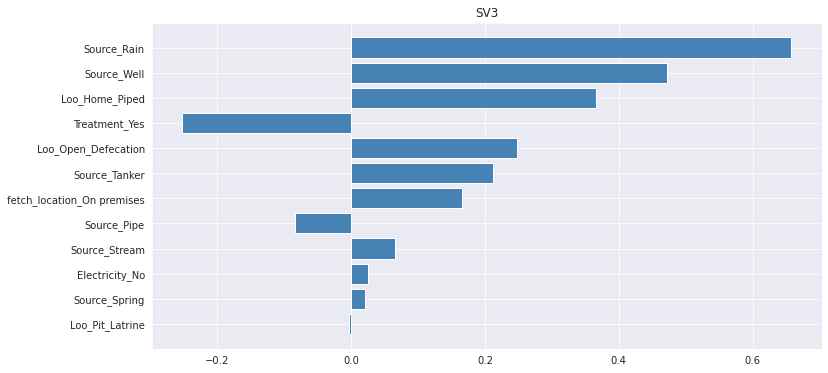

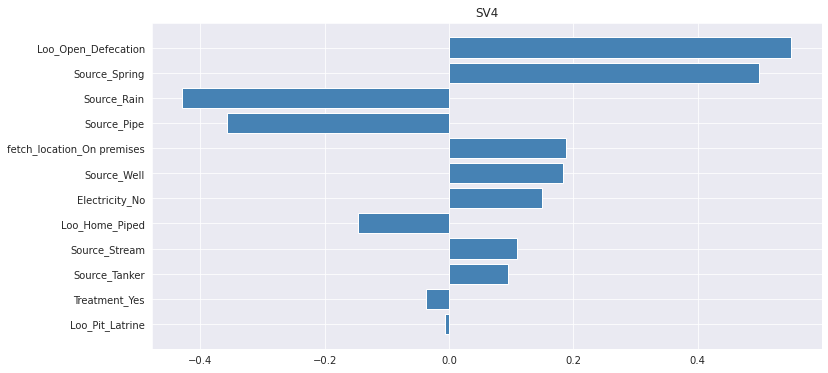

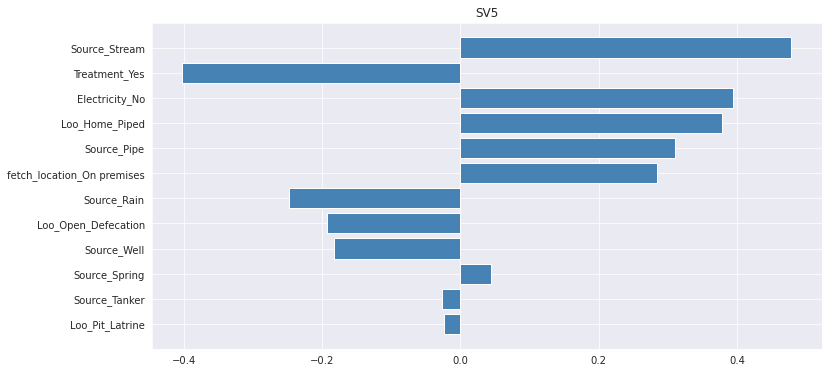

In [367]:
feature_names = df_province_norm.columns
for i in range(5):
    fig, ax = plt.subplots(figsize=(12, 6))
    order = np.argsort(np.abs(p_svd[:, i]))[-20:]
    ax.barh([feature_names[o] for o in order], p_svd[order, i], color='steelblue')
    ax.set_title(f'SV{i+1}')

### Kmeans

  0%|          | 0/8 [00:00<?, ?it/s]

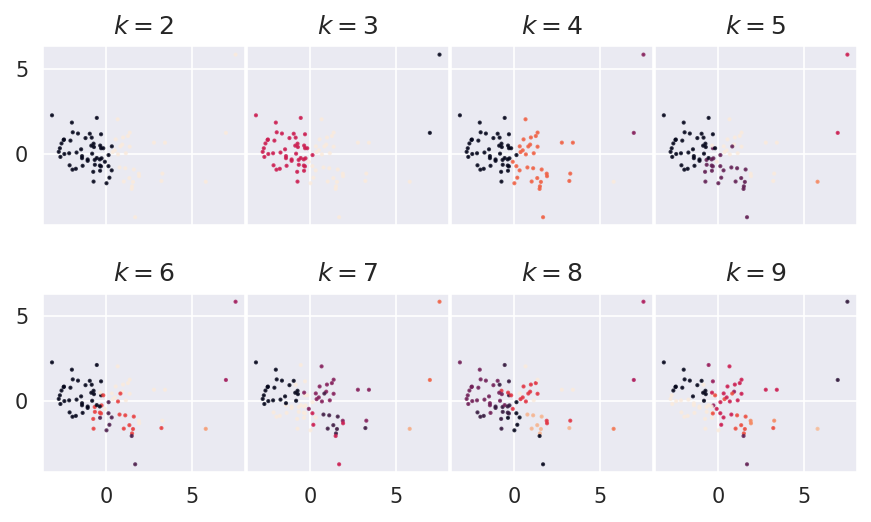

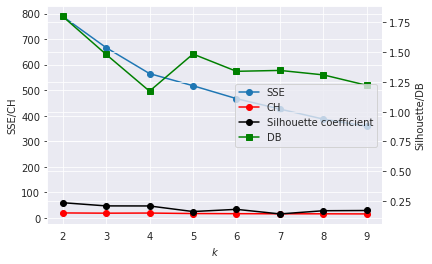

In [368]:
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
# KMeans
res_soccer = cluster_range(X_new_svd, KMeans(random_state=1337), 2, 9)
plot_clusters(X_new_svd, res_soccer['ys'], res_soccer['centers']);

plot_internal(res_soccer['inertias'], res_soccer['chs'], res_soccer['scs'],
              res_soccer['dbs']);

- SSE - Elbow at k=4
- CH - Highest at k=2, next highest at k=3
- SC - Nearest to 0.5 is k=2
- DB - Closest to 0 is k=4

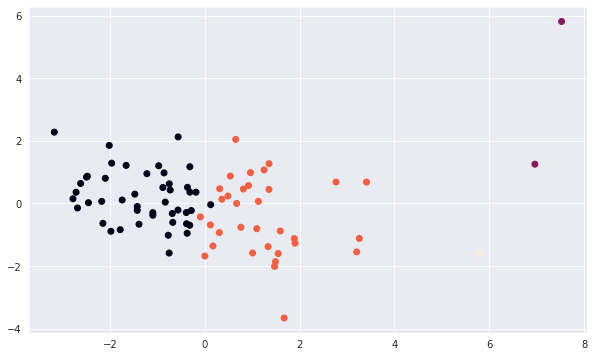

In [369]:
# k=2
fig, ax = plt.subplots(figsize=(10, 6))
cluster_labels = KMeans(4, random_state=1337).fit_predict(X_new_svd)
plt.scatter(X_new_svd[:,0], X_new_svd[:,1], c=cluster_labels, alpha=1);

#### With Province Labels

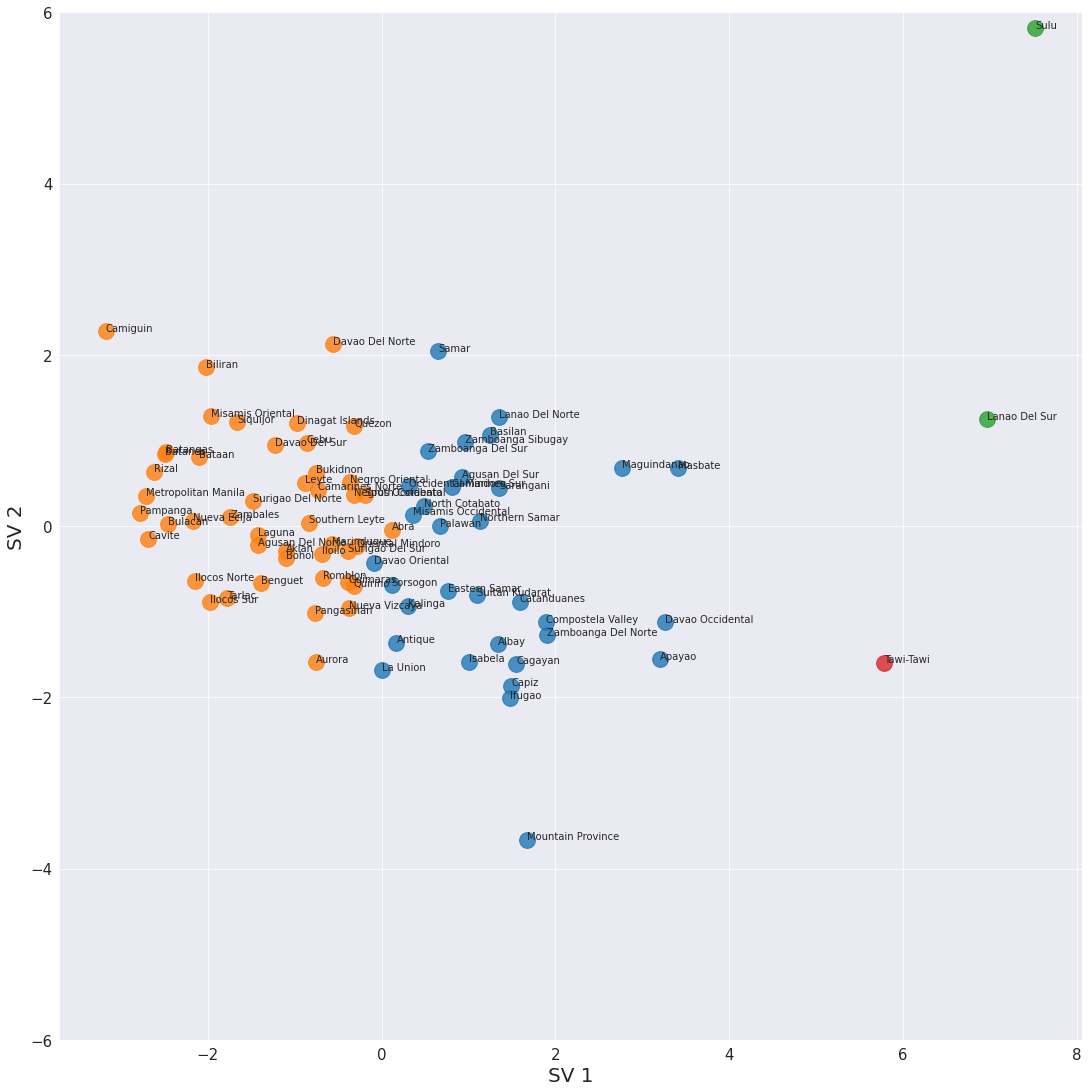

In [370]:
reduced = pd.DataFrame(X_new_svd[:, :2])
reduced['cluster'] = clusters
reduced['name'] = df_province_norm.index
reduced.columns = ['x', 'y', 'cluster', 'name']

%matplotlib inline
# sns.set(style="white")
ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
fit_reg=False, size = 15, scatter_kws={"s": 250})
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s, fontstretch='ultra-expanded'))
ax.set(ylim=(-6, 6))

plt.tick_params(labelsize=15)
plt.xlabel("SV 1", fontsize = 20)
plt.ylabel("SV 2", fontsize = 20)
plt.show();

#### With Both PCA Axis and Province Labels

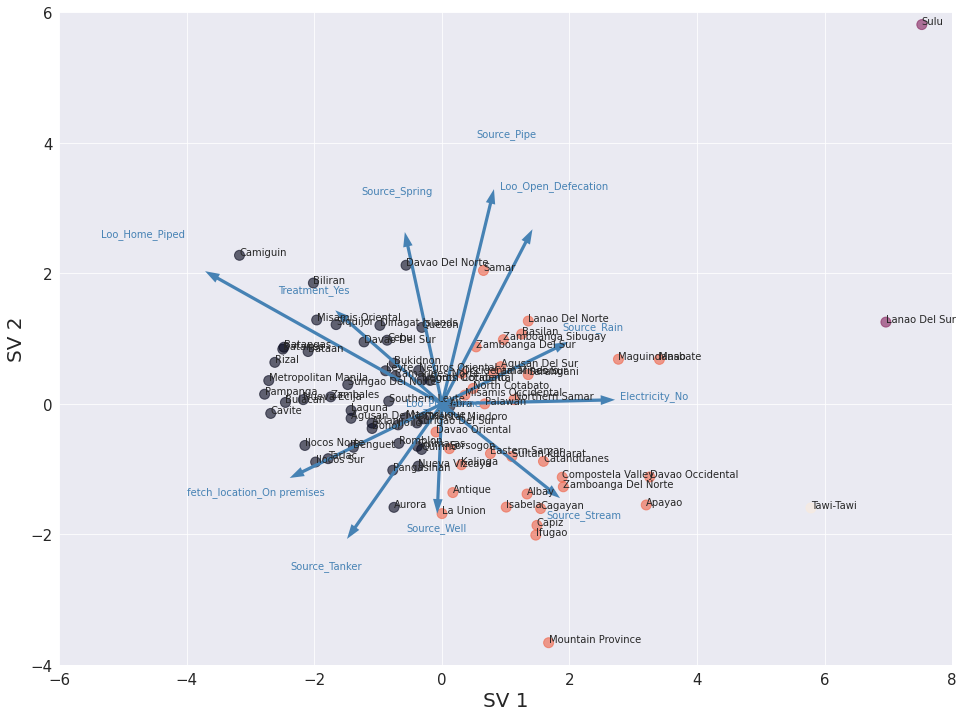

In [371]:
# kmeans code k=2
fig, ax = plt.subplots(figsize=(16, 12))
cluster_labels = KMeans(4, random_state=1337).fit_predict(X_new_svd)
plt.scatter(X_new_svd[:,0], X_new_svd[:,1], c=cluster_labels, alpha=0.6, s=100);

# Text Code
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s, fontstretch='ultra-expanded'))
ax.set(ylim=(-6, 6))

# Feature Importance Code
features = df_province_norm.columns
for feature, vec in zip(features, w_pca):
    ax.arrow(0, 0, 6*vec[0], 6*vec[1], width=0.05, ec='none', fc='steelblue')
    ax.text(8*vec[0], 8*vec[1], feature, ha='center', color='steelblue')
    
ax.set(ylim=(-4, 6))
ax.set(xlim=(-6, 8))
plt.tick_params(labelsize=15)
plt.xlabel("SV 1", fontsize = 20)
plt.ylabel("SV 2", fontsize = 20)
plt.show();

#### Clustering with PCA Axis

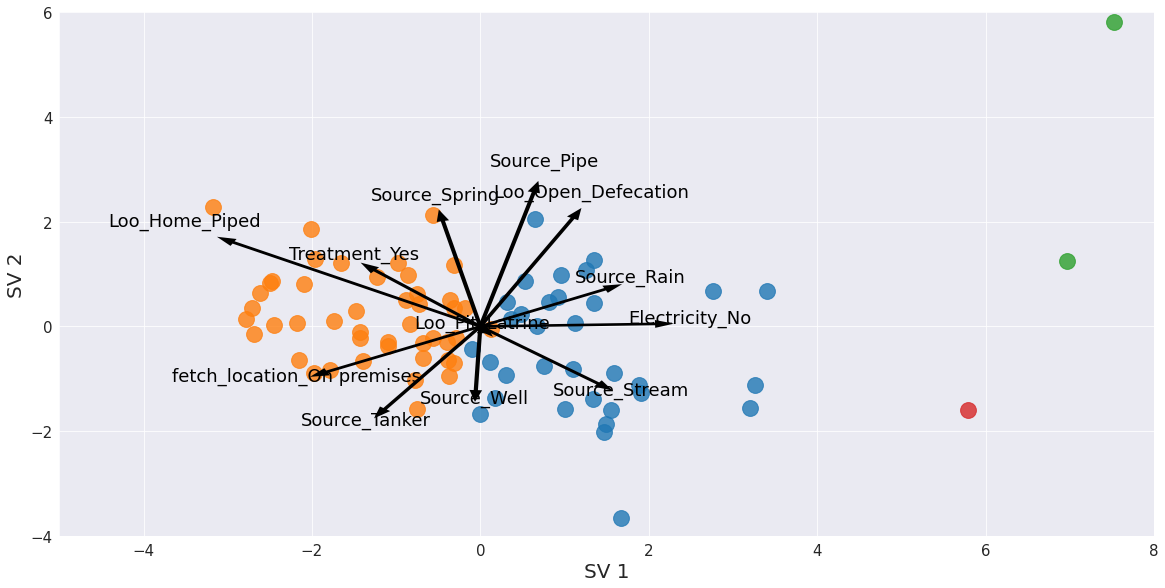

In [372]:
reduced = pd.DataFrame(X_new_svd[:, :2])
reduced['cluster'] = clusters
reduced['name'] = df_province_norm.index
reduced.columns = ['x', 'y', 'cluster', 'name']

%matplotlib inline
# sns.set(style="white")
ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
fit_reg=False, size = 8, scatter_kws={"s": 250}, height=6, aspect=2)
# texts = []
# for x, y, s in zip(reduced.x, reduced.y, reduced.name):
#     texts.append(plt.text(x, y, s, fontstretch='ultra-expanded'))
    
# Feature Importance Code
features = df_province_norm.columns
for feature, vec in zip(features, w_pca):
    plt.arrow(0, 0, 5*vec[0], 5*vec[1], width=0.05, ec='none', fc='black')
    plt.text(6*vec[0], 6*vec[1], feature, ha='center', color='black', size=18)
    
ax.set(ylim=(-4, 6))
ax.set(xlim=(-5, 8))
plt.tick_params(labelsize=15)
plt.xlabel("SV 1", fontsize = 20)
plt.ylabel("SV 2", fontsize = 20)
plt.savefig('feature_importance.png', transparent=True)
plt.show();

#### Clustering with labels

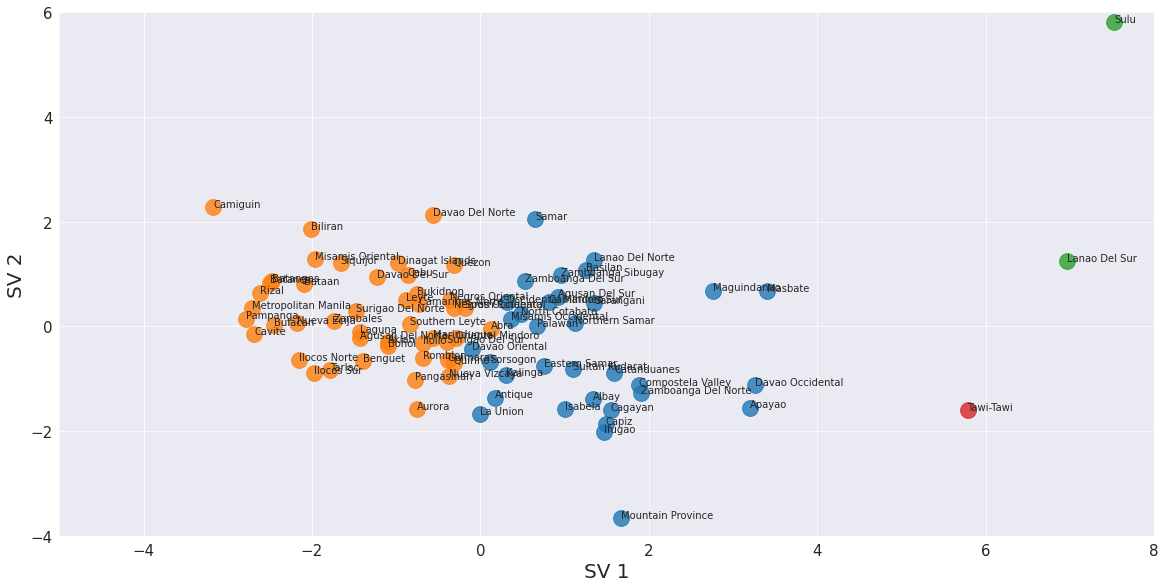

In [373]:
reduced = pd.DataFrame(X_new_svd[:, :2])
reduced['cluster'] = clusters
reduced['name'] = df_province_norm.index
reduced.columns = ['x', 'y', 'cluster', 'name']

%matplotlib inline
# sns.set(style="white")
ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
fit_reg=False, size = 8, scatter_kws={"s": 250}, height=6, aspect=2)
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s, fontstretch='ultra-expanded'))
    
# Feature Importance Code
# features = df_province_norm.columns
# for feature, vec in zip(features, w_pca):
#     plt.arrow(0, 0, 6*vec[0], 6*vec[1], width=0.05, ec='none', fc='steelblue')
#     plt.text(8*vec[0], 8*vec[1], feature, ha='center', color='steelblue')
    
ax.set(ylim=(-4, 6))
ax.set(xlim=(-5, 8))
plt.tick_params(labelsize=15)
plt.xlabel("SV 1", fontsize = 20)
plt.ylabel("SV 2", fontsize = 20)
plt.savefig('data_labels.png', transparent=True)
plt.show();

#### Feature Importance per Axis

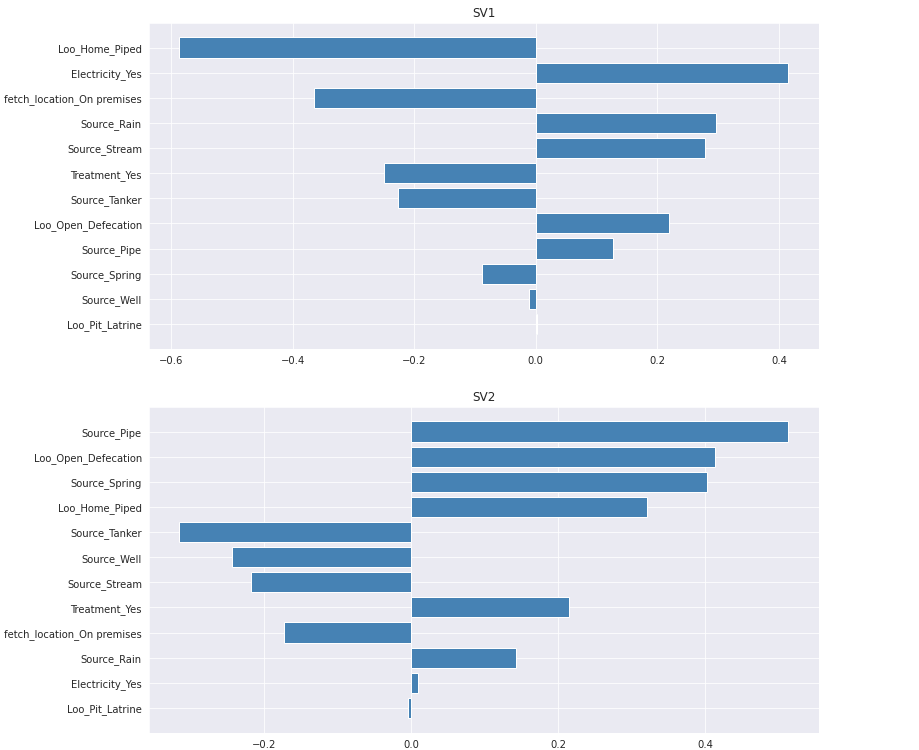

#### Plotting the clusters

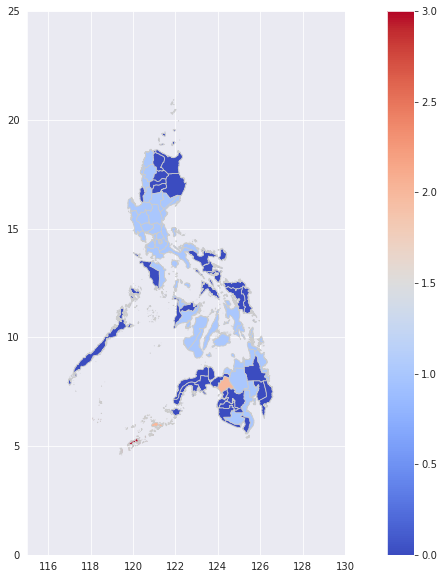

In [374]:
unsafe_graph_df = pd.merge(shapefile, reduced, left_on = 'PROVINCE_', right_on = 'name')
plot_province(unsafe_graph_df, 'cluster', color='coolwarm')

In [375]:
def bin_data(df, col, bins=3):
    """Bin the data based on their percentile ranking"""
    df['pct_score'] = df['cluster'].copy()
    
    df.loc[df[df.pct_score == 3].index, 'pct_label'] = 'Cluster 3'
    df.loc[df[df.pct_score == 2].index, 'pct_label'] = 'Cluster 2'
    df.loc[df[df.pct_score == 1].index, 'pct_label'] = 'Cluster 1'
    df.loc[df[df.pct_score == 0].index, 'pct_label'] = 'Cluster 0'
    return df

In [376]:
import matplotlib.patches as mpatches
def plot_map(df_binned, fig_title, img_title, save_fig=False):
    """Plot the binned map with Low, Medium, High scaling"""
    df_binned.plot(figsize=(20,20),
                   column='pct_score',
                   categorical=True,
                   color=df_poor_toilet_binned['color'],
#                         legend=True,
                   edgecolor='black',
                   linewidth=0.5)

    # Create the legend
    
    # If reverse: Priority to help is High
    cluster2_patch = mpatches.Patch(color='#4DAB48', label='Top Priority')
    cluster3_patch = mpatches.Patch(color='#D54A45', label='Priority 2')
    cluster0_patch = mpatches.Patch(color='#438AB5', label='Priority 3') 
    cluster1_patch = mpatches.Patch(color='#F69030', label='Least Priority')
    
    
    
        
    leg = plt.legend(handles=[cluster2_patch, cluster3_patch, cluster0_patch, cluster1_patch], fontsize=13,
               loc='upper left', title=f'{fig_title}',
               title_fontsize=14)
    leg._legend_box.align = 'left'
    
    # Annotate texts
    # df_no_water_binned.apply(lambda z: ax.annotate(text=z['NAME_1'], color='black', # white
    #                                    xy=z.geometry.representative_point().coords[0],
    #                                    ha='center', fontsize=12)
    #                                    if z['pct_label'] == 'Low' else 'Error', axis=1)
    plt.axis('off');
    
    if save_fig:
        plt.savefig(f'{img_title}.png', dpi=150, bbox_inches='tight')

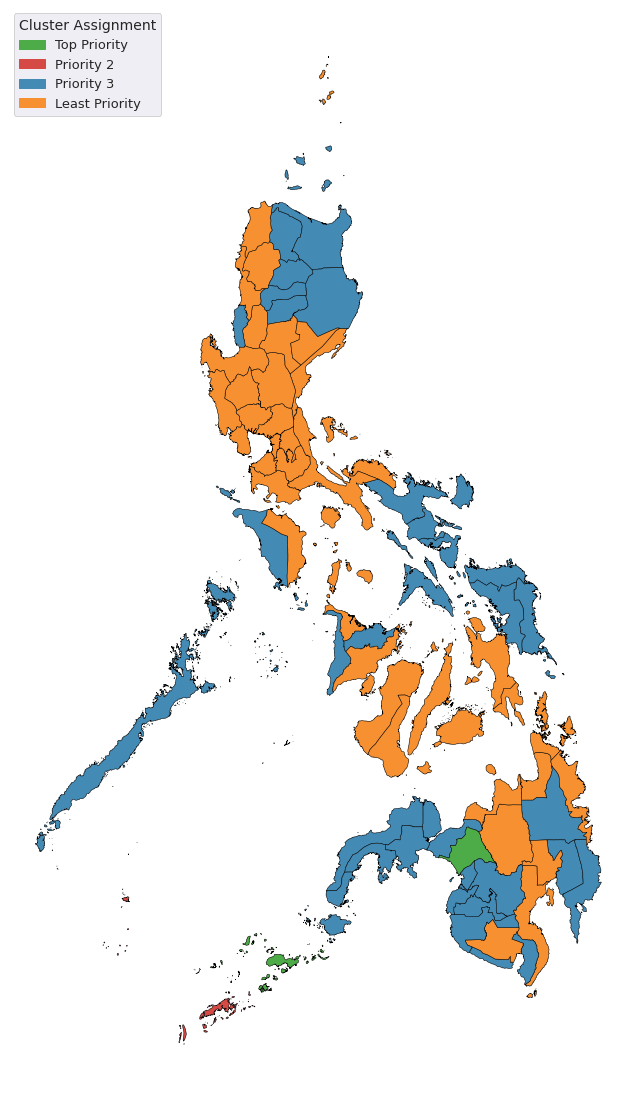

In [377]:
df_poor_toilet_binned = bin_data(unsafe_graph_df, 'poor_toilet_prop')
df_poor_toilet_binned.loc[df_poor_toilet_binned['cluster'] == 0, 'color'] = '#438AB5'
df_poor_toilet_binned.loc[df_poor_toilet_binned['cluster'] == 1, 'color'] = '#F69030'
df_poor_toilet_binned.loc[df_poor_toilet_binned['cluster'] == 2, 'color'] = '#4DAB48'
df_poor_toilet_binned.loc[df_poor_toilet_binned['cluster'] == 3, 'color'] = '#D54A45'
fig_title = 'Cluster Assignment'
img_title = 'cluster_assignment'

plot_map(df_poor_toilet_binned, fig_title, img_title, True)

In [378]:
df_new.loc[(df_new['clusters'] == 3) | (df_new['clusters'] == 2)]

fetch_location_On premises  Source_Pipe  Source_Rain  \
SHPROV                                                                
Lanao Del Sur                    0.286957     0.069565     0.008696   
Sulu                             0.423197     0.379310     0.018809   
Tawi-Tawi                        0.680751     0.018779     0.516432   

               Source_Spring  Source_Stream  Source_Tanker  Source_Well  \
SHPROV                                                                    
Lanao Del Sur       0.437681       0.078261       0.060870     0.330435   
Sulu                0.018809       0.050157       0.141066     0.332288   
Tawi-Tawi           0.014085       0.000000       0.018779     0.338028   

               Treatment_Yes  Electricity_No  Loo_Home_Piped  \
SHPROV                                                         
Lanao Del Sur       0.255072        0.947826        0.055072   
Sulu                0.598746        0.655172        0.147335   
Tawi-Tawi           0.873239        0.788732        0.215962   

               Loo_Open_Defecation  Loo_Pit_Latrine  clusters  
SHPROV                                                         
Lanao Del Sur             0.124638         0.727536         2  
Sulu                      0.379310         0.470219         2  
Tawi-Tawi                 0.098592         0.685446         3

# Normalizing by Population Instead of Households

## Access to Water

### Proportion of households without an on-premise water source

In [533]:
no_water_labels = ['Off premises']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV201', 'HV204', 'HV237']].copy()
temp.loc[(temp['HV204'] != 'On premises'), 'HV204'] = 'Off premises'
hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'), tot_pop=('HV009', 'sum'))
naw = temp[temp['HV204'].isin(no_water_labels)].groupby('SHPROV', as_index=False).agg(no_water=('HHID', 'count'), no_water_pop=('HV009', 'sum'))

no_water = pd.merge(naw, hh, on='SHPROV')
no_water['no_water_prop_pop'] = no_water['no_water_pop'] / no_water['tot_pop']
no_water['On premises'] = no_water['tot_pop'] - no_water['no_water_pop']
no_water['Off premises'] = no_water['no_water_pop']



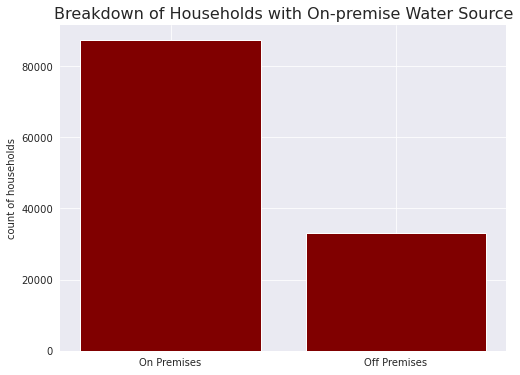

In [534]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

data = {'On Premises':no_water['On premises'].sum(), 'Off Premises':no_water['Off premises'].sum()}
courses = list(data.keys())
values = list(data.values())
 
# creating the bar plot
plt.bar(courses, values, color ='maroon')

# temp['HV204'].value_counts().plot(kind='bar', color=['#8d0a11']*2 + ['#666666']*3)


plt.title('Breakdown of Households with On-premise Water Source', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

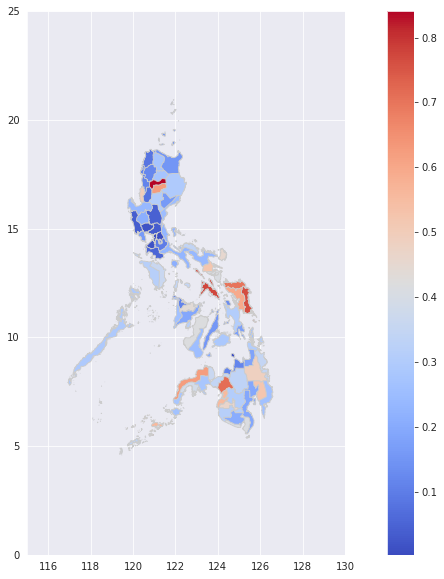

In [537]:
no_water_graph_df = pd.merge(shapefile, no_water, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(no_water_graph_df, 'no_water_prop_pop', color='coolwarm')

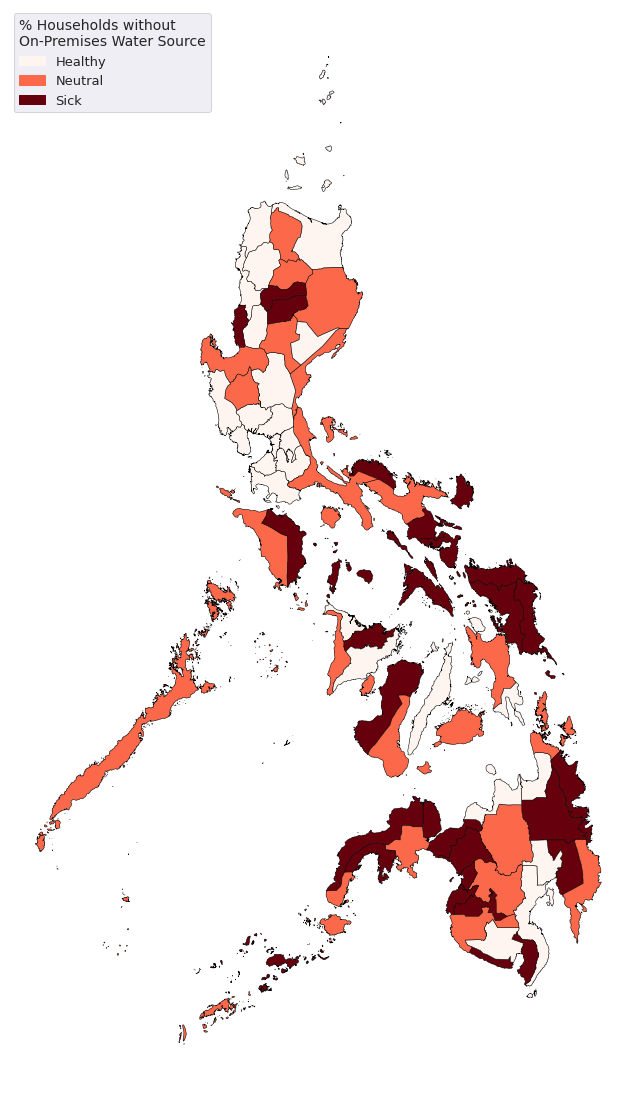

In [538]:
df_no_water_binned = bin_data(no_water_graph_df, 'no_water_prop_pop')

fig_title = '% Households without\nOn-Premises Water Source'
img_title = 'eda_access_to_water1'

plot_map(df_no_water_binned, fig_title, img_title, True) #

In [539]:
no_water.sort_values('no_water_prop_pop', ascending=False).head(5)

SHPROV  no_water  no_water_pop  households  tot_pop  \
50  Mountain Province       231         938.0         274   1116.0   
46            Masbate       229        1037.0         294   1338.0   
31      Eastern Samar       203         850.0         262   1114.0   
42      Lanao Del Sur       246        1382.0         345   1940.0   
54     Northern Samar       200        1022.0         293   1456.0   

    no_water_prop_pop  On premises  Off premises  
50           0.840502        178.0         938.0  
46           0.775037        301.0        1037.0  
31           0.763016        264.0         850.0  
42           0.712371        558.0        1382.0  
54           0.701923        434.0        1022.0

### Proportion of households with no access to safe drinking water

In [540]:
no_water_labels = ['Unbottled water']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV201', 'HV204', 'HV237']].copy()
temp.loc[(temp['HV204'] != 'On premises'), 'HV204'] = 'Off premises'
temp.loc[(temp['HV201'] != 'Bottled water'), 'HV201'] = 'Unbottled water'
temp['is_unsafe'] = 'With Access to Potable Water'
temp.loc[((temp['HV201'] == 'Unbottled water') & (temp['HV237']== 'No')), 'is_unsafe'] = 'No Access to Potable Water'
hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'), tot_pop=('HV009', 'sum'))
unsafe = temp.loc[(temp['HV201']== 'Unbottled water') &
               (temp['HV237']== 'No')].groupby('SHPROV', as_index=False).agg(unsafe=('HHID', 'count'), unsafe_pop=('HV009', 'sum'))

unsafe = pd.merge(unsafe, hh, on='SHPROV')
unsafe['unsafe_prop'] = unsafe['unsafe_pop'] / unsafe['tot_pop']

unsafe['with_access'] = unsafe['tot_pop'] - unsafe['unsafe_pop']
unsafe['no_access'] = unsafe['unsafe_pop']

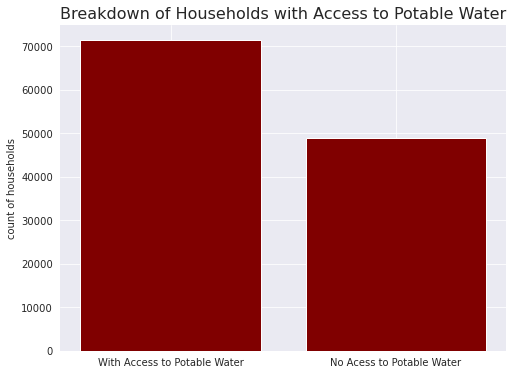

In [428]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

data = {'With Access to Potable Water':unsafe['with_access'].sum(),
        'No Acess to Potable Water':unsafe['no_access'].sum()}
courses = list(data.keys())
values = list(data.values())
 
# creating the bar plot
plt.bar(courses, values, color ='maroon')

# temp['is_unsafe'].value_counts().plot(kind='bar', color=['#8d0a11']*2 + ['#666666']*3)

plt.title('Breakdown of Households with Access to Potable Water', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

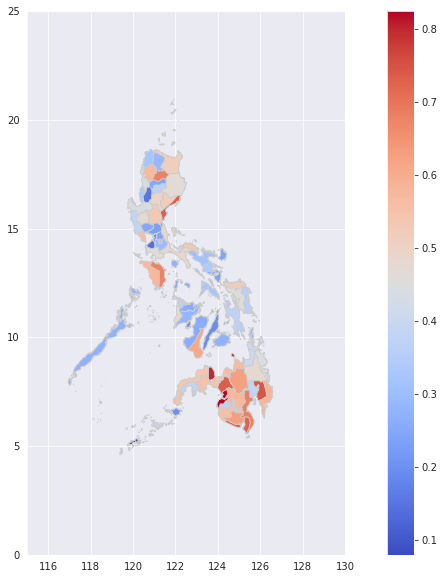

In [541]:
unsafe_graph_df = pd.merge(shapefile, unsafe, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(unsafe_graph_df, 'unsafe_prop', color='coolwarm')

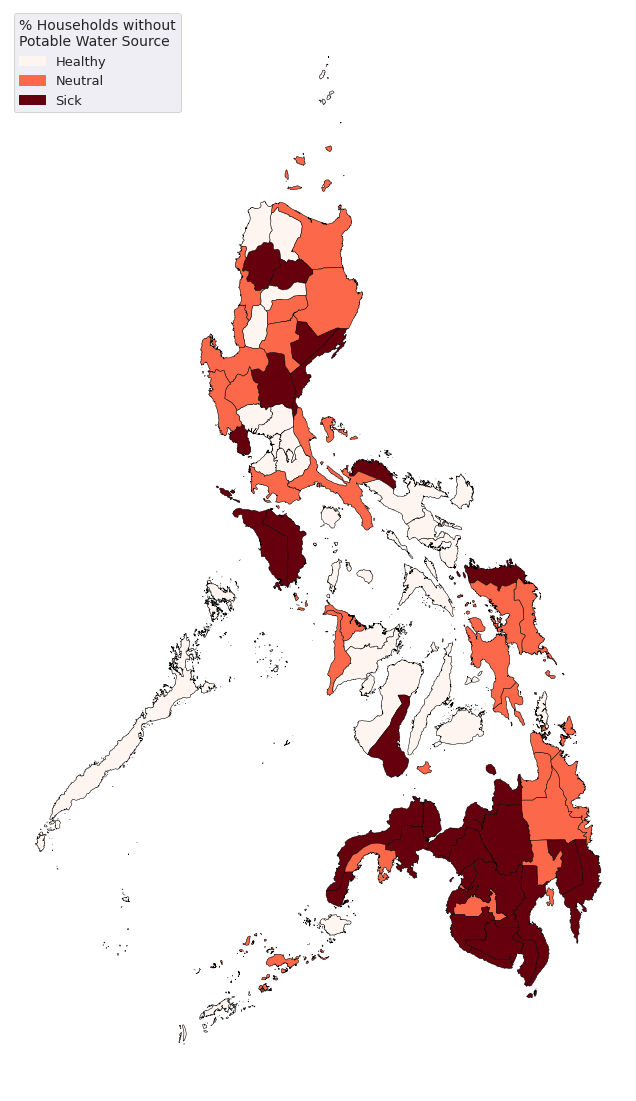

In [542]:
df_unsafe_water_binned = bin_data(unsafe_graph_df, 'unsafe_prop')

fig_title = '% Households without\nPotable Water Source'
img_title = 'eda_access_to_water2'

plot_map(df_unsafe_water_binned, fig_title, img_title, True)

In [543]:
unsafe.sort_values('unsafe_prop', ascending=False).head(5)

SHPROV  unsafe  unsafe_pop  households  tot_pop  unsafe_prop  \
28    Davao Occidental     242       964.0         294   1169.0     0.824636   
48  Misamis Occidental     223       964.0         275   1203.0     0.801330   
20            Camiguin     230       963.0         285   1231.0     0.782291   
25   Compostela Valley     210       818.0         267   1100.0     0.743636   
42       Lanao Del Sur     252      1426.0         345   1940.0     0.735052   

    with_access  no_access  
28        205.0      964.0  
48        239.0      964.0  
20        268.0      963.0  
25        282.0      818.0  
42        514.0     1426.0

## Access to Electricity

In [544]:
no_electric_labels = ['No']

temp = df[['HHID', 'SHPROV', 'HV009', 'HV206']].copy()


hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'), tot_pop=('HV009', 'sum'))
no_elec = temp[temp['HV206'].isin(no_electric_labels)].groupby('SHPROV', as_index=False).agg(no_elec=('HHID', 'count'), no_elec_pop=('HV009', 'sum'))

no_elec = pd.merge(no_elec, hh, on='SHPROV')
no_elec['no_elec_prop'] = no_elec['no_elec_pop'] / no_elec['tot_pop']
no_elec['Yes'] = no_elec['tot_pop'] - no_elec['no_elec_pop']
no_elec['No'] = no_elec['no_elec_pop']

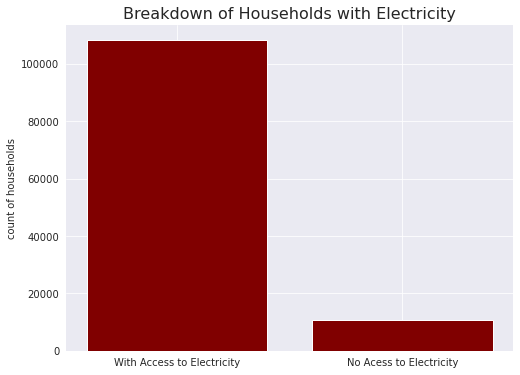

In [545]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

data = {'With Access to Electricity':no_elec['Yes'].sum(),
        'No Acess to Electricity':no_elec['No'].sum()}
courses = list(data.keys())
values = list(data.values())
 
# creating the bar plot
plt.bar(courses, values, color ='maroon')

plt.title('Breakdown of Households with Electricity', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

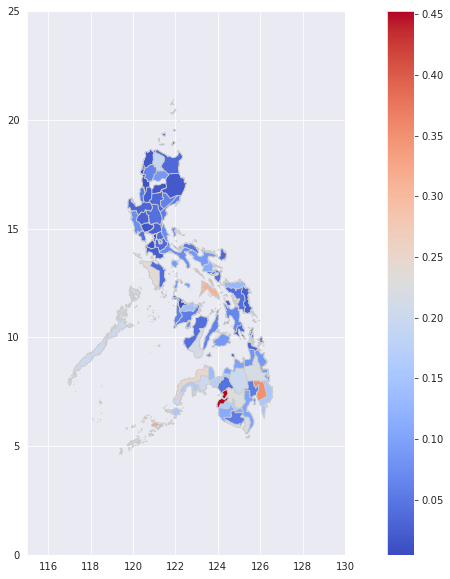

In [546]:
no_elec_graph_df = pd.merge(shapefile, no_elec, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(no_elec_graph_df, 'no_elec_prop', color='coolwarm')

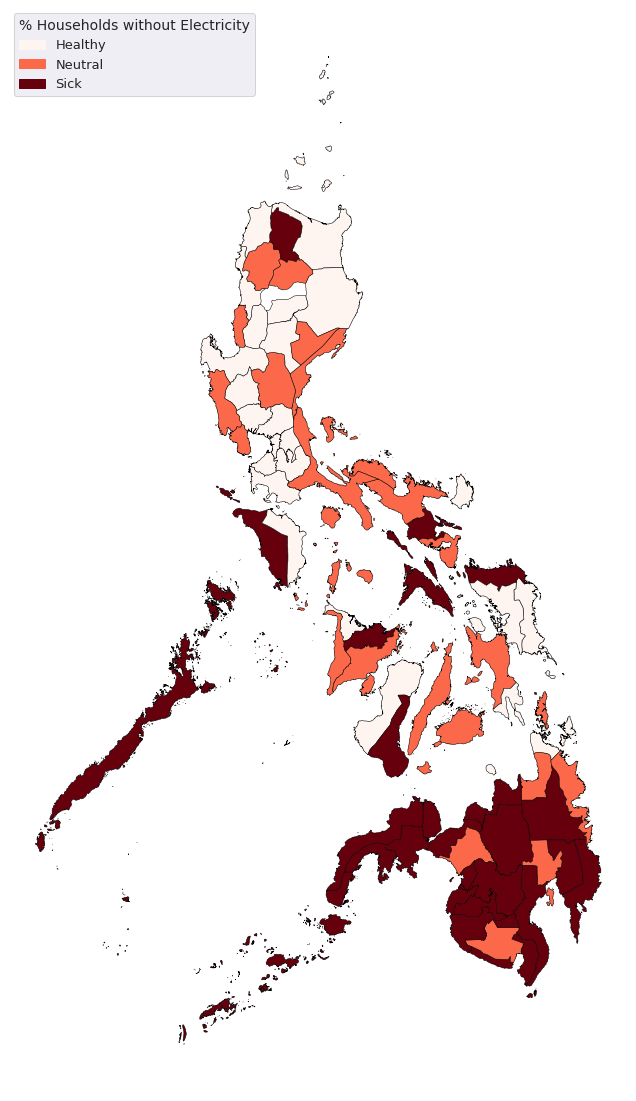

In [547]:
df_no_elec_binned = bin_data(no_elec_graph_df, 'no_elec_prop')

fig_title = '% Households without Electricity'
img_title = 'eda_access_to_elec'

plot_map(df_no_elec_binned, fig_title, img_title, True)

In [548]:
no_elec.sort_values('no_elec_prop', ascending=False).head(5)

SHPROV  no_elec  no_elec_pop  households  tot_pop  \
28     Davao Occidental      133        529.0         294   1169.0   
25    Compostela Valley       99        387.0         267   1100.0   
72                 Sulu      110        598.0         319   1834.0   
46              Masbate       96        418.0         294   1338.0   
78  Zamboanga Del Norte       60        254.0         250   1018.0   

    no_elec_prop     Yes     No  
28      0.452524   640.0  529.0  
25      0.351818   713.0  387.0  
72      0.326063  1236.0  598.0  
46      0.312407   920.0  418.0  
78      0.249509   764.0  254.0

## Access to Toilet

In [549]:
poor_toilet_labels = ['Composting toilet', 'Flush to pit latrine', 'Hanging toilet/latrine',
                      'Flush to somewhere else', "Flush, don't know where", 'No facility/bush/field',
                      'Pit latrine with slab', 'Public toilet', 'Pit latrine without slab/open pit',
                      'Ventilated Improved Pit latrine (VIP)', 'Bucket toilet', 'Other']

temp = df[['HHID','SHPROV', 'HV009', 'HV205']].copy()

hh = temp.groupby('SHPROV', as_index=False).agg(households=('HHID', 'count'), tot_pop=('HV009', 'sum'))
poor_toilet = temp[temp['HV205'].isin(poor_toilet_labels)].groupby('SHPROV', as_index=False).agg(poor_toilet=('HHID', 'count'), poor_toilet_pop=('HV009', 'sum'))

poor_toilet = pd.merge(poor_toilet, hh, on='SHPROV')
poor_toilet['poor_toilet_prop'] = poor_toilet['poor_toilet_pop'] / poor_toilet['tot_pop']
poor_toilet['Yes'] = poor_toilet['tot_pop'] - poor_toilet['poor_toilet_pop']
poor_toilet['No'] = poor_toilet['poor_toilet_pop']

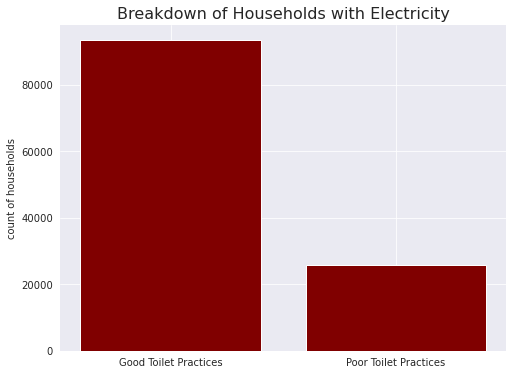

In [550]:
fig, ax = plt.subplots(figsize=(8,6))

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    

data = {'Good Toilet Practices':poor_toilet['Yes'].sum(),
        'Poor Toilet Practices':poor_toilet['No'].sum()}
courses = list(data.keys())
values = list(data.values())
 
# creating the bar plot
plt.bar(courses, values, color ='maroon')

plt.title('Breakdown of Households with Electricity', fontsize=16)
plt.ylabel('count of households')
plt.xticks(rotation=0)
plt.show()

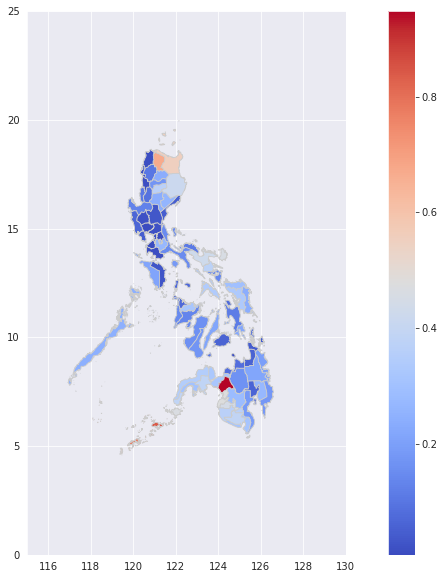

In [551]:
poor_toilet_graph_df = pd.merge(shapefile, poor_toilet, left_on = 'PROVINCE_', right_on = 'SHPROV')
plot_province(poor_toilet_graph_df, 'poor_toilet_prop', color='coolwarm')

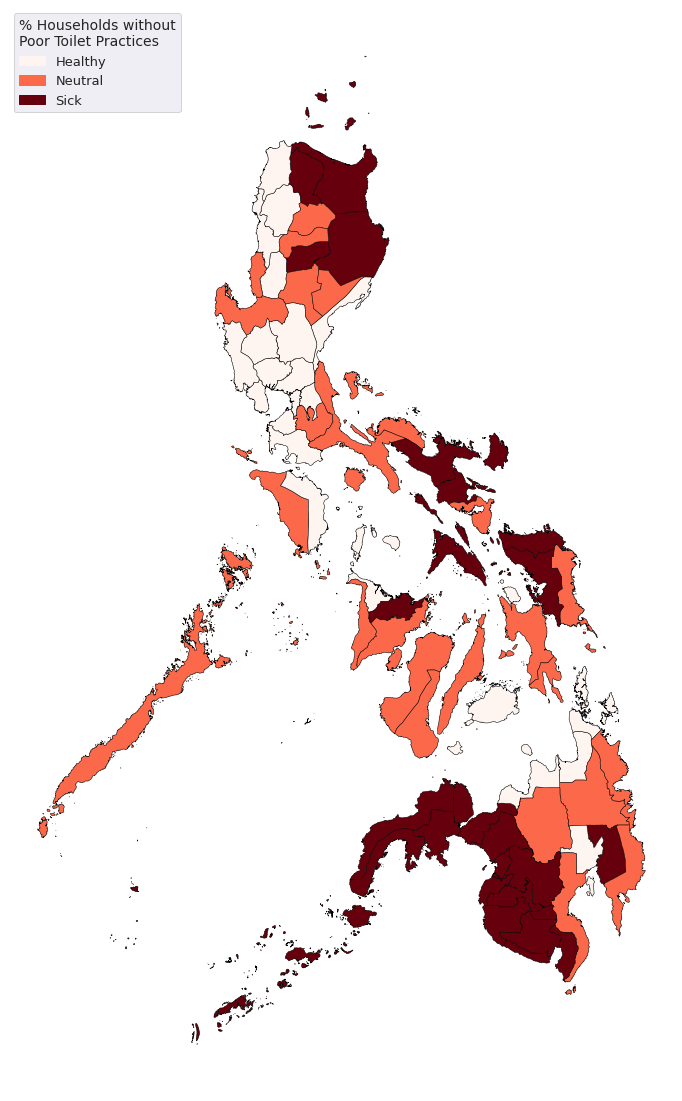

In [552]:
df_poor_toilet_binned = bin_data(poor_toilet_graph_df, 'poor_toilet_prop')

fig_title = '% Households without\nPoor Toilet Practices'
img_title = 'eda_access_to_toilet'

plot_map(df_poor_toilet_binned, fig_title, img_title, True)

In [553]:
poor_toilet.sort_values('poor_toilet_prop', ascending=False).head(5)

SHPROV  poor_toilet  poor_toilet_pop  households  tot_pop  \
41  Lanao Del Sur          326           1839.0         345   1940.0   
72           Sulu          272           1537.0         319   1834.0   
76      Tawi-Tawi          167            922.0         213   1164.0   
6          Apayao          178            895.0         274   1336.0   
16        Cagayan          161            634.0         278   1148.0   

    poor_toilet_prop    Yes      No  
41          0.947938  101.0  1839.0  
72          0.838059  297.0  1537.0  
76          0.792096  242.0   922.0  
6           0.669910  441.0   895.0  
16          0.552265  514.0   634.0

## Poverty Index

In [563]:
df_off = no_water[['SHPROV', 'no_water_prop_pop']]
df_unsafe = unsafe[['SHPROV', 'unsafe_prop']]
df_noelec = no_elec[['SHPROV', 'no_elec_prop']]
df_poorpoop = poor_toilet[['SHPROV', 'poor_toilet_prop']]

df_index = df_off.merge(df_unsafe, on='SHPROV', how='left')
df_index = df_index.merge(df_noelec, on='SHPROV', how='left')
df_index = df_index.merge(df_poorpoop, on='SHPROV', how='left')
df_index['pov_index'] = ((0.25 * df_index['no_water_prop_pop']) +
                         (0.25 * df_index['unsafe_prop']) +
                         (0.25 * df_index['no_elec_prop']) +
                         (0.25 * df_index['poor_toilet_prop']))
df_index = df_index.sort_values('pov_index', ascending=False)
df_index

SHPROV  no_water_prop_pop  unsafe_prop  no_elec_prop  \
42        Lanao Del Sur           0.712371     0.735052      0.043814   
28     Davao Occidental           0.556031     0.824636      0.452524   
73                 Sulu           0.558888     0.376772      0.326063   
25    Compostela Valley           0.520909     0.743636      0.351818   
79  Zamboanga Del Norte           0.622790     0.537328      0.249509   
..                  ...                ...          ...           ...   
60             Pampanga           0.019417     0.246966      0.014563   
47  Metropolitan Manila           0.003739     0.202486      0.009498   
23               Cavite           0.016965     0.141376      0.012253   
10              Batanes           0.037415     0.303855      0.004535   
50    Mountain Province           0.840502     0.248208           NaN   

    poor_toilet_prop  pov_index  
42          0.947938   0.609794  
28          0.476476   0.577417  
73          0.838059   0.524945  
25          0.269091   0.471364  
79          0.348723   0.439587  
..               ...        ...  
60          0.007888   0.072209  
47          0.020612   0.059084  
23          0.007540   0.044533  
10               NaN        NaN  
50          0.170251        NaN  

[82 rows x 6 columns]